In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [4]:
# dati = pd.read_csv('Bitcoin (€) da yfinance dal 06-05-2022 alle 21 al 05-05-2024 alle 19 con granularità oraria.csv')
# dati = dati[['Datetime', 'Close']]
# dati = dati.rename(columns = {'Datetime':'Timestamp', 'Close': 'Price'})
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
# dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d %H')
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d %H')
# dati

In [5]:
data_inizio = '2020-02-29'
data_fine = '2020-09-01'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2020-02-29,7798.025879
1,2020-03-01,7748.164551
2,2020-03-02,7959.358398
3,2020-03-03,7862.485352
4,2020-03-04,7861.055176
...,...,...
181,2020-08-28,9695.468750
182,2020-08-29,9664.351562
183,2020-08-30,9824.922852
184,2020-08-31,9785.023438


In [6]:
# data_inizio = '2023-06-01 00'
# data_fine = '2023-12-01 00'
# indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
# indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
# dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
# dati

### Eventuale cambio dati

In [7]:
def calcola_prezzo(t):
    return dati['Price'][t] #1000 - t + 100 * math.sin(2*math.pi * t / 4)

In [8]:
dati['Price'] = dati.index.map(calcola_prezzo)
dati

,Timestamp,Price
0,2020-02-29,7798.025879
1,2020-03-01,7748.164551
2,2020-03-02,7959.358398
3,2020-03-03,7862.485352
4,2020-03-04,7861.055176
...,...,...
181,2020-08-28,9695.468750
182,2020-08-29,9664.351562
183,2020-08-30,9824.922852
184,2020-08-31,9785.023438


### Strategia 1: media pesata forzata

#### Strategia con variabili statiche

In [9]:
# dati = generated_dfs[0]

500.0 512.60189357995 1.0252037871599
506.300946789975 519.8965160130539 1.0268527430360872
513.0987314015144 512.6435414396957 0.9991128608707034
512.8711364206051 516.9693919007489 1.0079908093653818
514.920264160677 515.795517555751 1.0016997843277748
515.357890858214 517.0193441640582 1.003223882539331
516.188617511136 528.2729209814769 1.0234106352995669
522.2307692463064 525.8291441656198 1.006890392392058
524.0299567059631 526.6998495305899 1.0050949240410028
525.3649031182765 526.7698735729371 1.0026742754346958
526.0673883456068 535.4651278265071 1.0178641362097252
530.766258086057 532.7101572829537 1.0036624392890128
531.7382076845054 538.403185221508 1.0125343212894664
535.0706964530067 585.9123357678214 1.0950185454965948
560.4915161104141 565.9132630256272 1.0096732006807845
563.2023895680206 577.498341674741 1.0253833299920576
570.3503656213809 580.200867315403 1.017270965861993
575.275616468392 598.9098849162762 1.0410833829408148
587.092750692334 593.6247047087099 1.011

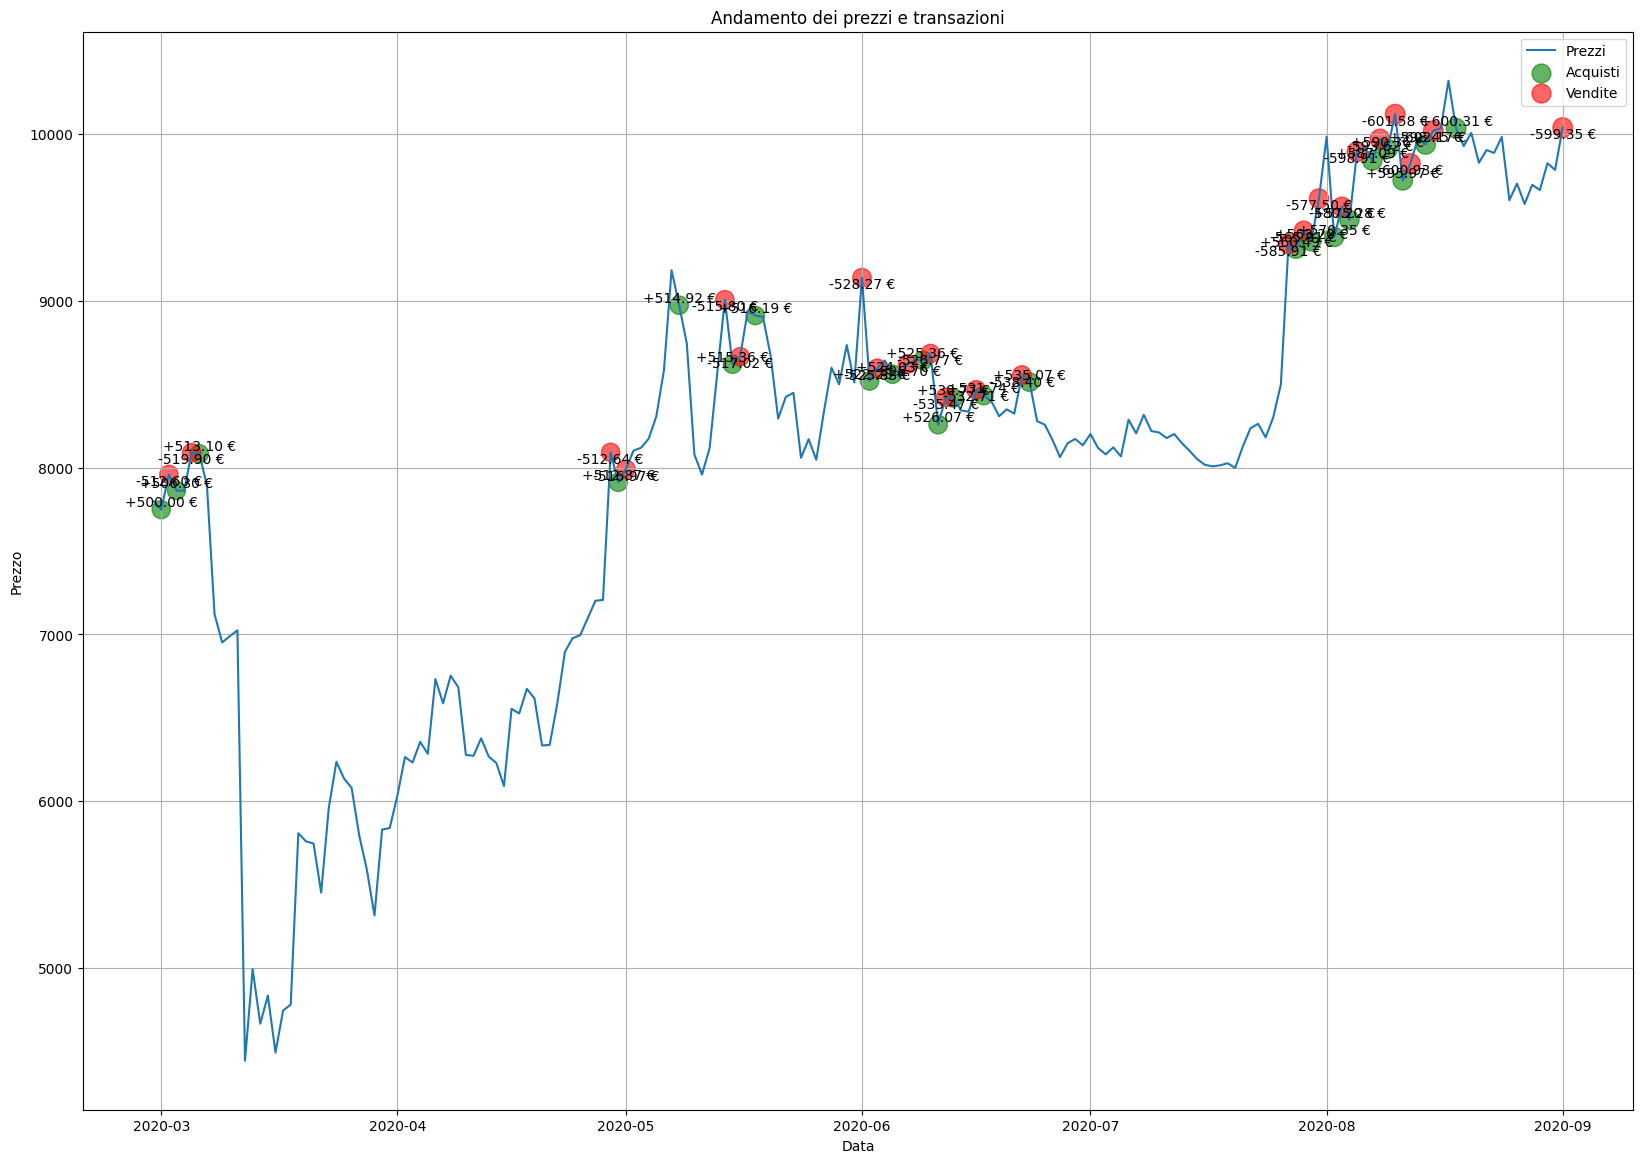

In [10]:
# Inizializzazione dei parametri fissi
liquidita_mobile_iniziale = 1000
liquidita_fissa_iniziale = 0
bitcoin_iniziali = 0
perc_commissione_acquisto = 0.001
perc_commissione_vendita = 0.001
min_acquisto = 5
min_vendita = 5


# Inizializzazione dei parametri variabili 
perc_primo_acquisto = 0.5
vendita_immediata = True
perc_sbilanciamento_acquisto = 7/10
soglia_minima_acquisto = 0 # Percentuale minima di cui il prezzo dev'essere sotto al prezzo dell'ultimo acquisto per poter acquistare (viene applicato a tutti gli acquisti esclusi i primi acquisti)
soglia_minima_vendita = 0 # Percentuale minima di cui il prezzo dev'essere sopra alla media pesata di acquisto per poter vendere
perc_stop_loss = 0 # Utile solo in caso di vendita_immediata = False: per vendere, l'algoritmo aspetta che il prezzo scenda almeno di una percentuale perc_stop_loss rispetto al massimo mai raggiunto durante una salita (se vende in questo modo, viene ricalcolato da capo da lì in poi; si aggiorna solo durante le salite, non durante le discese); se perc_stop_loss = 0, semplicemente vende non appena il prezzo scende rispetto al massimo
compra_pure = False # Se è True, nel caso ci fosse bisogno di un acquisto che è superiore alla somma tra liquidità mobile e liquidità fissa, compra con tutto quello che ha (quindi prima fa una ricarica della liquidità mobile con la liquidità fissa che ha, e se anche questa non basta compra con tutta la liquidità mobile rimasta; anche se così facendo non rispetterà la percentuale di sbilanciamento richiesta); se è False, in questi casi non fa niente

liquidita_mobile = liquidita_mobile_iniziale
liquidita_fissa = liquidita_fissa_iniziale
bitcoin = bitcoin_iniziali

ultima_azione_effettiva = None
ultimi_acquisti = []
transazioni = pd.DataFrame(columns=['Data', 'Numero giorno', 'Prezzo', 'Ultima Azione', 'Azione Attuale', '% acquisto/vendita di LM', 'Quantità in € Comprata/Venduta', 'Quantità di Bitcoin Comprati/Venduti', 'Liquidità Mobile', 'Liquidità Fissa', 'Bitcoin Posseduti', 'Valore Totale del Portafoglio'])
giorni_acquisto = []
giorni_vendita = []

prezzo_massimo = 0
in_salita = False

valori_portafoglio = [] # Solo per debug
rapporti_valori_portafoglio = []

def aggiorna_transazioni(i, azione, perc, quantita_euro, quantita_btc):
    global transazioni, liquidita_mobile, liquidita_fissa, bitcoin, ultima_azione_effettiva
    ultima_azione = ultima_azione_effettiva if ultima_azione_effettiva else "-"
    nuova_transazione = pd.DataFrame({
        'Data': [dati['Timestamp'].iloc[i]],
        'Numero giorno': i,
        'Prezzo': [dati['Price'].iloc[i]],
        'Ultima Azione': [ultima_azione],
        'Azione Attuale': [azione],
        '% acquisto/vendita di LM': [perc],
        'Quantità in € Comprata/Venduta': [quantita_euro],
        'Quantità di Bitcoin Comprati/Venduti': [quantita_btc],
        'Liquidità Mobile': [liquidita_mobile],
        'Liquidità Fissa': [liquidita_fissa],
        'Bitcoin Posseduti': [bitcoin],
        'Valore Totale del Portafoglio': [liquidita_mobile + liquidita_fissa + bitcoin * dati['Price'].iloc[i]]
    })
    transazioni = pd.concat([transazioni, nuova_transazione], ignore_index=True)
    if azione != "-":
        ultima_azione_effettiva = azione

def primo_acquisto(i):
    global liquidita_mobile, bitcoin, ultimi_acquisti
    quantita_primo_acquisto = liquidita_mobile * perc_primo_acquisto
    bitcoin_acquistati = quantita_primo_acquisto / dati['Price'].iloc[i] * (1 - perc_commissione_acquisto)
    liquidita_mobile -= quantita_primo_acquisto
    bitcoin += bitcoin_acquistati
    ultimi_acquisti = [(dati['Price'].iloc[i], quantita_primo_acquisto)]
    giorni_acquisto.append(i)
    aggiorna_transazioni(i, 'Primo Acquisto', perc_primo_acquisto, quantita_primo_acquisto, bitcoin_acquistati)

def calcola_prezzo_medio_pesato():
    return sum([euro*prezzo for prezzo, euro in ultimi_acquisti]) / sum([euro for _ , euro in ultimi_acquisti])

# Primo acquisto al giorno 1
primo_acquisto(1)

for i in range(2, len(dati)):
    prezzo_oggi = dati['Price'].iloc[i]
    prezzo_ieri = dati['Price'].iloc[i-1]
    prezzo_laltro_ieri = dati['Price'].iloc[i-2]
    azione = "-"  # Inizializziamo l'azione come nulla
    
    if bitcoin > 0:
        prezzo_medio_pesato = calcola_prezzo_medio_pesato()
        
        # Aggiorna il prezzo massimo se siamo in una salita
        if prezzo_oggi > prezzo_ieri:
            in_salita = True
            if prezzo_ieri < prezzo_laltro_ieri:
                prezzo_massimo = 0  # Reset del prezzo massimo se il giorno precedente è finita una discesa
            prezzo_massimo = max(prezzo_massimo, prezzo_oggi)
        else:
            in_salita = False
        
        if vendita_immediata:
            if prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
                # Vendita immediata
                quantita_venduta = bitcoin
                ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
                if ricavo >= min_vendita:
                    liquidita_mobile += ricavo
                    bitcoin = 0
                    giorni_vendita.append(i)
                    azione = 'Vendita'
                    aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
                    print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]))
                    ultimi_acquisti = []
        else:
            if not in_salita and prezzo_oggi <= prezzo_massimo * (1 - perc_stop_loss) and prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
                # Vendita con stop-loss
                quantita_venduta = bitcoin
                ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
                if ricavo >= min_vendita:
                    liquidita_mobile += ricavo
                    bitcoin = 0
                    giorni_vendita.append(i)
                    azione = 'Vendita (Stop-Loss)'
                    aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
                    print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]), bitcoin*dati['Price'].iloc[i] + liquidita_mobile + liquidita_fissa)
                    valori_portafoglio.append(bitcoin*dati['Price'].iloc[i] + liquidita_mobile + liquidita_fissa) # Solo per debug
                    if len(valori_portafoglio) > 1:
                        print('Rapporti portafoglio:', valori_portafoglio[-1] / valori_portafoglio[-2])
                        rapporti_valori_portafoglio.append(valori_portafoglio[-1] / valori_portafoglio[-2])
                    ultimi_acquisti = []
    
    if azione != 'Vendita' and azione != 'Vendita (Stop-Loss)':  # Se non abbiamo venduto, consideriamo l'acquisto
        if not ultimi_acquisti:
            if prezzo_oggi < prezzo_ieri:
                # Primo acquisto dopo una vendita
                primo_acquisto(i)
                azione = 'Primo Acquisto'
                # prezzo_massimo = prezzo_oggi  # Inizializzo il prezzo massimo
        elif prezzo_oggi < ultimi_acquisti[-1][0] * (1 - soglia_minima_acquisto):
            # Calcolo del prezzo desiderato di acquisto
            ultimo_prezzo_acquisto = ultimi_acquisti[-1][0]
            A = perc_sbilanciamento_acquisto * prezzo_oggi + (1 - perc_sbilanciamento_acquisto) * ultimo_prezzo_acquisto # Prezzo a cui si vuole imporre la media pesata

            # Calcolo della quantità da acquistare
            S = sum([p * q for p, q in ultimi_acquisti])  # Questa è la somma pesata degli ultimi acquisti
            P = sum([q for _, q in ultimi_acquisti])  # Questa è la somma delle spese degli ultimi acquisti, cioè la somma dei pesi
            quantita_da_acquistare_euro = (S - A * P) / (A - prezzo_oggi)
            # print(i, A, S, P, quantita_da_acquistare_euro)

            if quantita_da_acquistare_euro >= min_acquisto:
                if quantita_da_acquistare_euro > liquidita_mobile:
                    # Usa la liquidità fissa se necessario
                    liquidita_aggiuntiva = min(liquidita_fissa, quantita_da_acquistare_euro - liquidita_mobile)
                    liquidita_mobile += liquidita_aggiuntiva
                    liquidita_fissa -= liquidita_aggiuntiva

                if quantita_da_acquistare_euro <= liquidita_mobile:
                    # Acquisto
                    bitcoin_acquistati = quantita_da_acquistare_euro / prezzo_oggi * (1 - perc_commissione_acquisto)
                    vecchia_liquidita_mobile = liquidita_mobile
                    liquidita_mobile -= quantita_da_acquistare_euro
                    bitcoin += bitcoin_acquistati
                    ultimi_acquisti.append((prezzo_oggi, quantita_da_acquistare_euro))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
                    giorni_acquisto.append(i)
                    azione = 'Acquisto'
                    aggiorna_transazioni(i, azione, quantita_da_acquistare_euro / vecchia_liquidita_mobile, quantita_da_acquistare_euro, bitcoin_acquistati)

                elif quantita_da_acquistare_euro > liquidita_mobile and compra_pure and liquidita_mobile != 0:
                        # Acquisto con tutto quello che rimane nella liquidità mobile anche se non viene rispettata la percentuale di sbilanciamento richiesta
                        bitcoin_acquistati = liquidita_mobile / prezzo_oggi * (1 - perc_commissione_acquisto)
                        vecchia_liquidita_mobile = liquidita_mobile
                        liquidita_mobile = 0
                        bitcoin += bitcoin_acquistati
                        ultimi_acquisti.append((prezzo_oggi, vecchia_liquidita_mobile))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
                        giorni_acquisto.append(i)
                        azione = 'Acquisto'
                        aggiorna_transazioni(i, azione, 1, vecchia_liquidita_mobile, bitcoin_acquistati)
    
    if azione == "-":
        # Se non è stata effettuata nessuna azione, aggiungiamo comunque una riga alla tabella
        aggiorna_transazioni(i, azione, 0, 0, 0)

    # print(i, prezzo_massimo)

# Grafico
# plt.figure(figsize=(20, 7))
# plt.grid(True)
# plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
# plt.scatter(dati['Timestamp'].iloc[giorni_acquisto], dati['Price'].iloc[giorni_acquisto], color='green', label='Acquisti')
# plt.scatter(dati['Timestamp'].iloc[giorni_vendita], dati['Price'].iloc[giorni_vendita], color='red', label='Vendite')
# plt.legend()
# plt.show()

etichette = True

# Preparazione dei dati per il grafico
acquisti = transazioni[transazioni['Azione Attuale'].isin(['Acquisto', 'Primo Acquisto'])]
vendite = transazioni[transazioni['Azione Attuale'].isin(['Vendita', 'Vendita (Stop-Loss)'])]

# Calcolo delle dimensioni dei punti
max_acquisto = acquisti['Quantità in € Comprata/Venduta'].max()
max_vendita = vendite['Quantità in € Comprata/Venduta'].max()

def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
    return min_size + (max_size - min_size) * (quantita / max_quantita)

dimensioni_acquisti = acquisti['Quantità in € Comprata/Venduta'].apply(lambda x: calcola_dimensione(x, max_acquisto))
dimensioni_vendite = vendite['Quantità in € Comprata/Venduta'].apply(lambda x: calcola_dimensione(x, max_vendita))

# Creazione del grafico
plt.figure(figsize=(20, 14))
plt.grid()
plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
if not acquisti.empty:
    plt.scatter(acquisti['Data'], acquisti['Prezzo'], s=dimensioni_acquisti, color='green', alpha=0.6, label='Acquisti')
    if etichette:
        for i, row in acquisti.iterrows():
            plt.text(row['Data'], row['Prezzo'], f"+{row['Quantità in € Comprata/Venduta']:.2f} €", 
                     color='black', ha='center', va='bottom')
if not vendite.empty:
    plt.scatter(vendite['Data'], vendite['Prezzo'], s=dimensioni_vendite, color='red', alpha=0.6, label='Vendite')
    if etichette:
        for i, row in vendite.iterrows():
            plt.text(row['Data'], row['Prezzo'], f"-{row['Quantità in € Comprata/Venduta']:.2f} €", 
                     color='black', ha='center', va='top')

plt.xlabel('Data')
plt.ylabel('Prezzo')
plt.title('Andamento dei prezzi e transazioni')
plt.legend()
plt.show()

In [11]:
# Possibili generalizzazioni della strategia:
# - Aggiungere un vincolo che fa comprare non solo se il prezzo è sceso ancora, ma se è sceso almeno di una certa percentuale (il caso attuale corrisponderebbe a una percentuale sempre pari a 0)
# - Permettere una vendita iniziale e varie vendite successive in modo analogo a quello che faccio con gli acquisti (il caso attuale corrisponderebbe a una vendita iniziale del 100%)

In [12]:
transazioni['Liquidità Fissa']

0      0
1      0
2      0
3      0
4      0
      ..
180    0
181    0
182    0
183    0
184    0
Name: Liquidità Fissa, Length: 185, dtype: object

In [13]:
# valori_portafoglio.insert(0, liquidita_fissa_iniziale+liquidita_mobile_iniziale)
# valori_portafoglio

In [14]:
# rapporti_valori_portafoglio.insert(0, valori_portafoglio[1]/(valori_portafoglio[0]))
# rapporti_valori_portafoglio

In [15]:
# np.mean(rapporti_valori_portafoglio)

In [16]:
# np.std(rapporti_valori_portafoglio)

1.063307315871488
1.0520177626991671
1.0088508468299762
1.048776812400282
1.0804335004677117
1.0009725122262394
1.0041442801195393
1.0886007354223353
1.0329187230068626
1.099986906594214
1.0264842188696206
1.078004441726938
1.0830433179968784
1.0807863691605295
1.061664404788127
1.0105287273480397
1.0081920990378381
1.08448362669877
1.0749220191461581
1.0887853549741306
1.0762181258762062
1.060761194986115
1.0796746846941856
1.0655149418490788


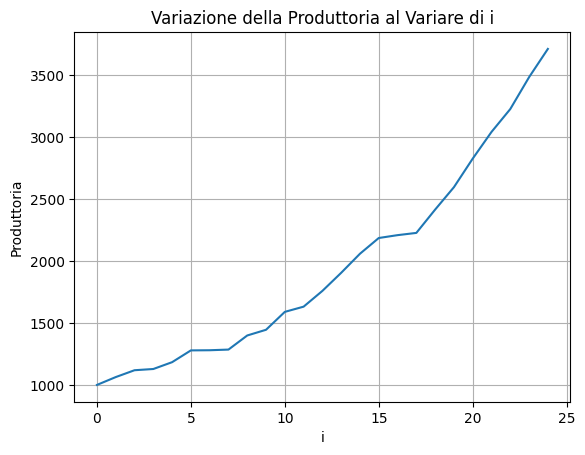

[1000,
 1063.307315871488,
 1118.6181835047794,
 1128.5189017082064,
 1183.564456467,
 1278.7626887298052,
 1280.0063010790536,
 1285.3110057455006,
 1399.1905061009734,
 1445.2500708051432,
 1589.7561546400184,
 1631.859604588831,
 1759.1519020215246,
 1905.2377128259116,
 2059.1549500328288,
 2186.1315143931283,
 2209.1486970551305,
 2227.246261970717,
 2415.412103733282,
 2596.379655615049,
 2826.9001449864422,
 3042.3611760764848,
 3227.2186767142543,
 3484.3463072206496,
 3712.623052920263]

In [17]:
# Inizializza la produttoria e la lista per memorizzare i valori
produttoria = 1000
valori = [produttoria]

# Calcola la produttoria per 100 volte
for i in range(1, 25):
    cas = random.uniform(1, 1.1)
    print(cas)
    produttoria *= cas
    valori.append(produttoria)

# Crea il grafico
plt.plot(valori)
plt.title('Variazione della Produttoria al Variare di i')
plt.xlabel('i')
plt.ylabel('Produttoria')
plt.grid()
plt.show()

valori

In [18]:
transazioni[:60]

,Data,Numero giorno,Prezzo,Ultima Azione,Azione Attuale,% acquisto/vendita di LM,Quantità in € Comprata/Venduta,Quantità di Bitcoin Comprati/Venduti,Liquidità Mobile,Liquidità Fissa,Bitcoin Posseduti,Valore Totale del Portafoglio
0,2020-03-01,1,7748.164551,-,Primo Acquisto,0.5,500.000000,0.064467,500.000000,0,0.064467,999.500000
1,2020-03-02,2,7959.358398,Primo Acquisto,Vendita,1.0,512.601894,0.064467,1012.601894,0,0.000000,1012.601894
2,2020-03-03,3,7862.485352,Vendita,Primo Acquisto,0.5,506.300947,0.064330,506.300947,0,0.064330,1012.095593
3,2020-03-04,4,7861.055176,Primo Acquisto,-,0.0,0.000000,0.000000,506.300947,0,0.064330,1012.003589
4,2020-03-05,5,8089.786133,Primo Acquisto,Vendita,1.0,519.896516,0.064330,1026.197463,0,0.000000,1026.197463
5,2020-03-06,6,8082.739746,Vendita,Primo Acquisto,0.5,513.098731,0.063417,513.098731,0,0.063417,1025.684364
6,2020-03-07,7,7894.343750,Primo Acquisto,-,0.0,0.000000,0.000000,513.098731,0,0.063417,1013.736796
7,2020-03-08,8,7121.034180,Primo Acquisto,-,0.0,0.000000,0.000000,513.098731,0,0.063417,964.695582
8,2020-03-09,9,6952.206055,Primo Acquisto,-,0.0,0.000000,0.000000,513.098731,0,0.063417,953.988956
9,2020-03-10,10,6989.210938,Primo Acquisto,-,0.0,0.000000,0.000000,513.098731,0,0.063417,956.335706


In [19]:
def calcola_rendimento_portafoglio_ideale(capitale_iniziale, bitcoin_iniziali, lista_prezzi, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [20]:
rendimento_ideale, portafoglio_finale_ideale = calcola_rendimento_portafoglio_ideale(liquidita_mobile_iniziale+liquidita_fissa_iniziale, bitcoin_iniziali, dati['Price'], min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita)
print('Rendimento ideale:', rendimento_ideale)
print('Portafoglio finale ideale in euro:', portafoglio_finale_ideale)

Rendimento ideale: 10.014867303574043
Portafoglio finale ideale in euro: 10014.867303574043


In [21]:
valore_iniziale = liquidita_fissa_iniziale+liquidita_mobile_iniziale + bitcoin_iniziali * dati['Price'][0]
valore_finale = liquidita_mobile + bitcoin * dati['Price'].iloc[-1]
rendimento = valore_finale / valore_iniziale

In [22]:
print(f"Rendimento del portafoglio: {rendimento}")
print(f'Punteggio rendimento: {round(rendimento / rendimento_ideale *100, 2)}%')
print(f"Valore finale del portafoglio in euro: {liquidita_mobile + bitcoin * dati['Price'].iloc[-1]}")

Rendimento del portafoglio: 1.199664249040099
Punteggio rendimento: 11.98%
Valore finale del portafoglio in euro: 1199.664249040099


##### Grafico andamenti

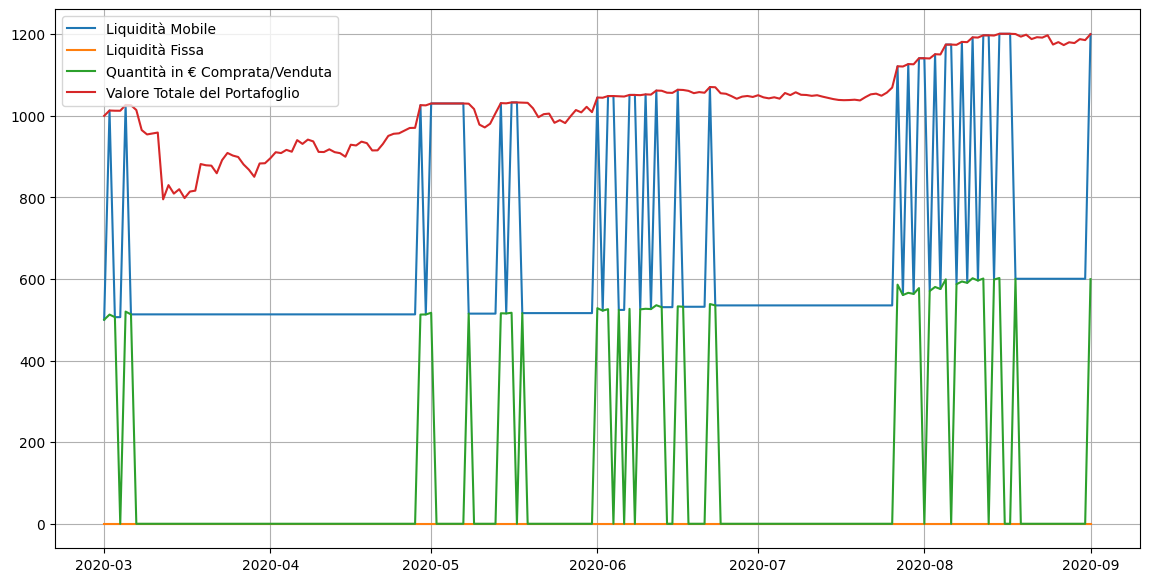

In [23]:
# Creiamo un DataFrame per memorizzare i dati del portafoglio
portafoglio = transazioni[['Data', 'Liquidità Mobile', 'Liquidità Fissa', 'Quantità in € Comprata/Venduta', 'Valore Totale del Portafoglio']]

# Creiamo un grafico multi-linea
plt.figure(figsize=(14,7))

# Grafico della liquidità mobile
plt.plot(portafoglio['Data'], portafoglio['Liquidità Mobile'], label='Liquidità Mobile')

# Grafico della liquidità fissa
plt.plot(portafoglio['Data'], portafoglio['Liquidità Fissa'], label='Liquidità Fissa')

# Grafico della quantità in euro comprata/venduta
plt.plot(portafoglio['Data'], portafoglio['Quantità in € Comprata/Venduta'], label='Quantità in € Comprata/Venduta')

# Grafico del valore totale del portafoglio
plt.plot(portafoglio['Data'], portafoglio['Valore Totale del Portafoglio'], label='Valore Totale del Portafoglio')

# Aggiungiamo una legenda
plt.legend()

plt.grid()

# Mostriamo il grafico
plt.show()

#### Strategia con variabili dinamiche

798.9194377394747 922.3864512321418 1.154542507867895 1123.4670134926673
37.44890044975551 41.41586502382212 1.1059300680774062 1127.4339780667337
Rapporti portafoglio: 1.0035310022692467
725.5642635360268 836.7750783380621 1.1532749342698483 1238.644792868769
Rapporti portafoglio: 1.0986406450094168
41.2881597622925 53.02854052397721 1.284352241157692 1250.3851736304537
Rapporti portafoglio: 1.0094784080385897
1250.3851736304537 1390.9976023857712 1.112455291154048 1390.9976023857712
Rapporti portafoglio: 1.112455291154048
903.2900832032913 1032.9811815837559 1.1435763558042702 1520.6887007662358
Rapporti portafoglio: 1.0932360330154594


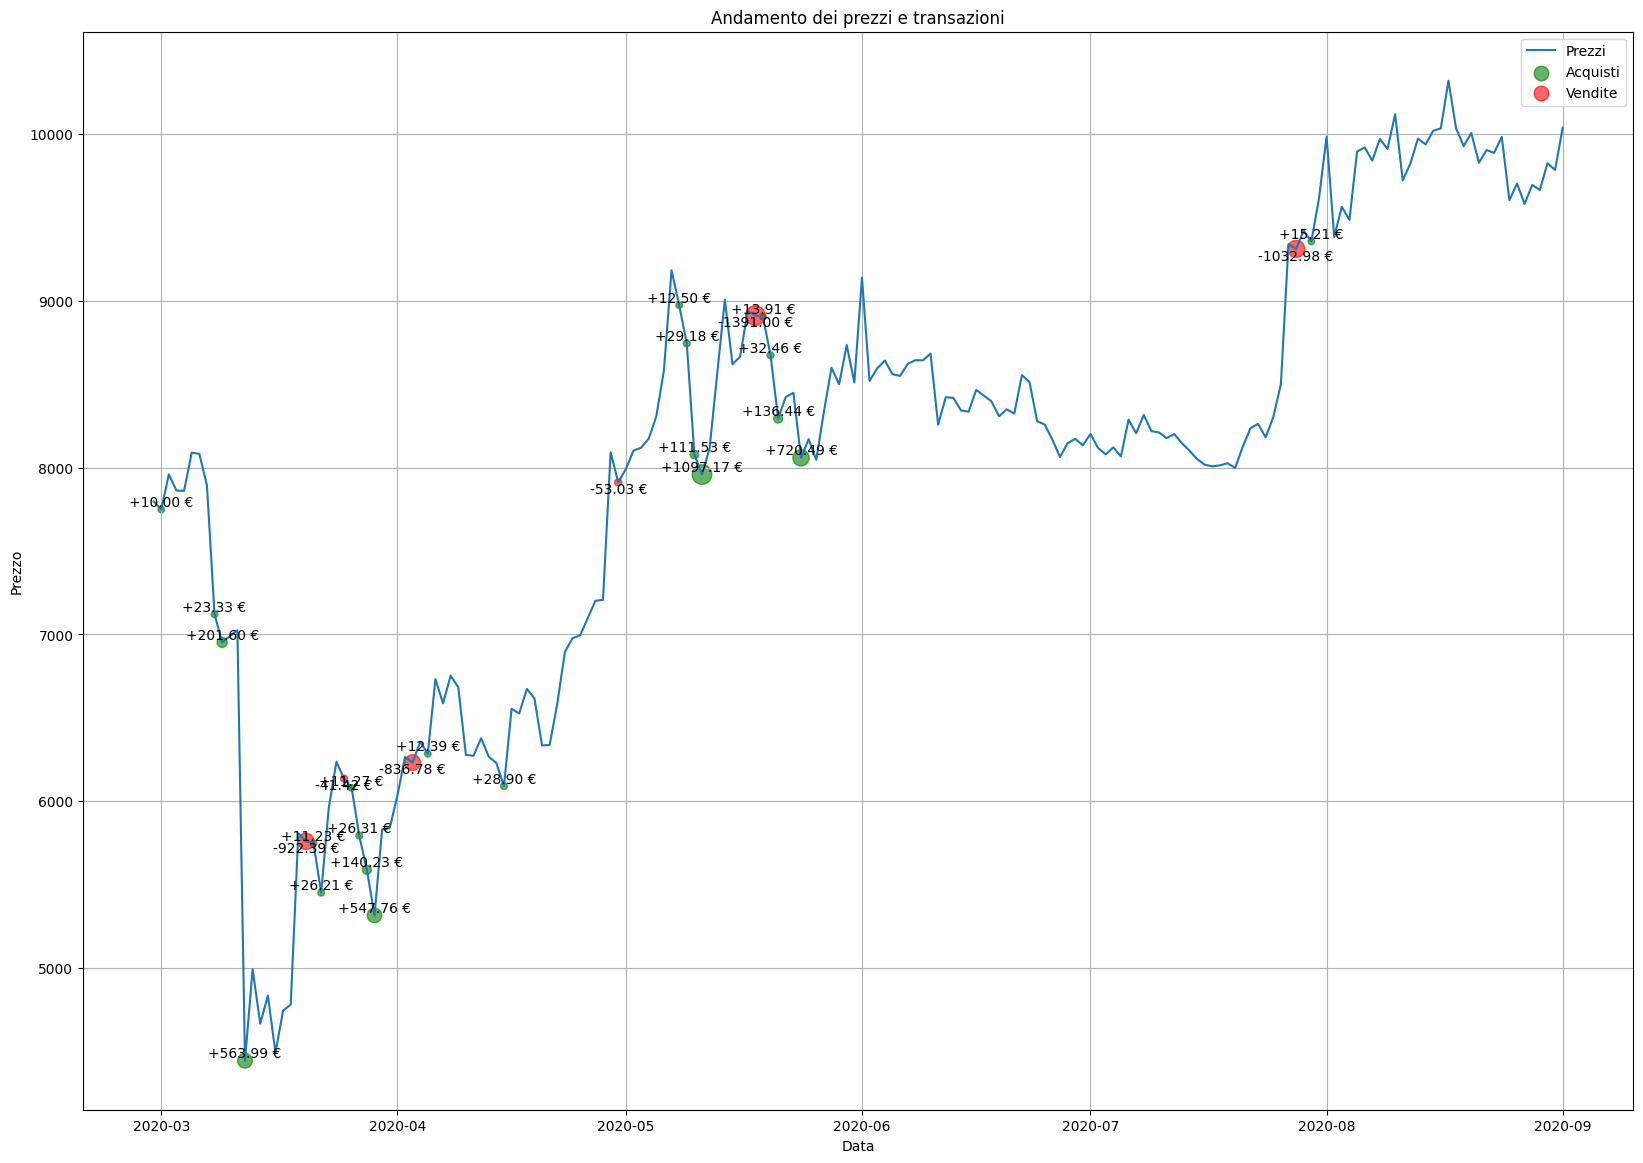

In [24]:
# Inizializzazione dei parametri fissi
liquidita_mobile_iniziale = 1000
liquidita_fissa_iniziale = 0
bitcoin_iniziali = 0
perc_commissione_acquisto = 0.001
perc_commissione_vendita = 0.001
min_acquisto = 5
min_vendita = 5


# Inizializzazione dei parametri variabili 
perc_primo_acquisto = 0.01
vendita_immediata = False
perc_sbilanciamento_acquisto = 7/10
soglia_minima_acquisto = 0.01 # Percentuale minima di cui il prezzo dev'essere sotto al prezzo dell'ultimo acquisto per poter acquistare (viene applicato a tutti gli acquisti esclusi i primi acquisti)
soglia_minima_vendita = 0.1 # Percentuale minima di cui il prezzo dev'essere sopra alla media pesata di acquisto per poter vendere
perc_stop_loss = 0.001 # Utile solo in caso di vendita_immediata = False: per vendere, l'algoritmo aspetta che il prezzo scenda almeno di una percentuale perc_stop_loss rispetto al massimo mai raggiunto durante una salita (se vende in questo modo, viene ricalcolato da capo da lì in poi; si aggiorna solo durante le salite, non durante le discese); se perc_stop_loss = 0, semplicemente vende non appena il prezzo scende rispetto al massimo
compra_pure = True # Se è True, nel caso ci fosse bisogno di un acquisto che è superiore alla somma tra liquidità mobile e liquidità fissa, compra con tutto quello che ha (quindi prima fa una ricarica della liquidità mobile con la liquidità fissa che ha, e se anche questa non basta compra con tutta la liquidità mobile rimasta; anche se così facendo non rispetterà la percentuale di sbilanciamento richiesta); se è False, in questi casi non fa niente
vendita_immediata_dinamica = False
tempo_rsi = 14
soglia_rsi = 50

liquidita_mobile = liquidita_mobile_iniziale
liquidita_fissa = liquidita_fissa_iniziale
bitcoin = bitcoin_iniziali

ultima_azione_effettiva = None
ultimi_acquisti = []
transazioni = pd.DataFrame(columns=['Data', 'Numero giorno', 'Prezzo', 'Ultima Azione', 'Azione Attuale', '% acquisto/vendita di LM', 'Quantità in € Comprata/Venduta', 'Quantità di Bitcoin Comprati/Venduti', 'Liquidità Mobile', 'Liquidità Fissa', 'Bitcoin Posseduti', 'Valore Totale del Portafoglio'])
giorni_acquisto = []
giorni_vendita = []

prezzo_massimo = 0
in_salita = False

valori_portafoglio = [] # Solo per debug
rapporti_valori_portafoglio = []

def aggiorna_transazioni(i, azione, perc, quantita_euro, quantita_btc):
    global transazioni, liquidita_mobile, liquidita_fissa, bitcoin, ultima_azione_effettiva
    ultima_azione = ultima_azione_effettiva if ultima_azione_effettiva else "-"
    nuova_transazione = pd.DataFrame({
        'Data': [dati['Timestamp'].iloc[i]],
        'Numero giorno': i,
        'Prezzo': [dati['Price'].iloc[i]],
        'Ultima Azione': [ultima_azione],
        'Azione Attuale': [azione],
        '% acquisto/vendita di LM': [perc],
        'Quantità in € Comprata/Venduta': [quantita_euro],
        'Quantità di Bitcoin Comprati/Venduti': [quantita_btc],
        'Liquidità Mobile': [liquidita_mobile],
        'Liquidità Fissa': [liquidita_fissa],
        'Bitcoin Posseduti': [bitcoin],
        'Valore Totale del Portafoglio': [liquidita_mobile + liquidita_fissa + bitcoin * dati['Price'].iloc[i]]
    })
    transazioni = pd.concat([transazioni, nuova_transazione], ignore_index=True)
    if azione != "-":
        ultima_azione_effettiva = azione

def primo_acquisto(i):
    global liquidita_mobile, bitcoin, ultimi_acquisti
    quantita_primo_acquisto = liquidita_mobile * perc_primo_acquisto
    bitcoin_acquistati = quantita_primo_acquisto / dati['Price'].iloc[i] * (1 - perc_commissione_acquisto)
    liquidita_mobile -= quantita_primo_acquisto
    bitcoin += bitcoin_acquistati
    ultimi_acquisti = [(dati['Price'].iloc[i], quantita_primo_acquisto)]
    giorni_acquisto.append(i)
    aggiorna_transazioni(i, 'Primo Acquisto', perc_primo_acquisto, quantita_primo_acquisto, bitcoin_acquistati)

def calcola_prezzo_medio_pesato():
    return sum([euro*prezzo for prezzo, euro in ultimi_acquisti]) / sum([euro for _ , euro in ultimi_acquisti])

def calculate_rsi(prices):
    if len(prices) < 2:
        raise ValueError("La lista dei prezzi deve contenere almeno 2 elementi per calcolare l'RSI.")

    # Calcola le variazioni di prezzo
    price_changes = [prices.iloc[k] - prices.iloc[k-1] for k in range(1, len(prices))]
    
    # Separa i guadagni e le perdite
    gains = [max(change, 0) for change in price_changes]
    losses = [abs(min(change, 0)) for change in price_changes]

    # Calcola la media dei guadagni e delle perdite
    avg_gain = sum(gains) / len(gains) if len(gains) != 0 else 0
    avg_loss = sum(losses) / len(losses) if len(losses) != 0 else 0

    rsi = 100 * avg_gain / (avg_gain + avg_loss)

    return rsi


# Primo acquisto al giorno 1
primo_acquisto(1)

for i in range(2, len(dati)):
    if vendita_immediata_dinamica:
        if i < tempo_rsi:
            dati_parziali = dati[:i]
        else:
            dati_parziali = dati[i-tempo_rsi:i]

        rsi = calculate_rsi(dati_parziali['Price'])

        if rsi > soglia_rsi:
            vendita_immediata = False
        else:
            vendita_immediata = True

    prezzo_oggi = dati['Price'].iloc[i]
    prezzo_ieri = dati['Price'].iloc[i-1]
    prezzo_laltro_ieri = dati['Price'].iloc[i-2]
    azione = "-"  # Inizializziamo l'azione come nulla
    
    if bitcoin > 0:
        prezzo_medio_pesato = calcola_prezzo_medio_pesato()
        
        # Aggiorna il prezzo massimo se siamo in una salita
        if prezzo_oggi > prezzo_ieri:
            in_salita = True
            if prezzo_ieri < prezzo_laltro_ieri:
                prezzo_massimo = 0  # Reset del prezzo massimo se il giorno precedente è finita una discesa
            prezzo_massimo = max(prezzo_massimo, prezzo_oggi)
        else:
            in_salita = False
        
        if vendita_immediata:
            if prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
                # Vendita immediata
                quantita_venduta = bitcoin
                ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
                if ricavo >= min_vendita:
                    liquidita_mobile += ricavo
                    bitcoin = 0
                    giorni_vendita.append(i)
                    azione = 'Vendita'
                    aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
                    print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]))
                    ultimi_acquisti = []
        else:
            if not in_salita and prezzo_oggi <= prezzo_massimo * (1 - perc_stop_loss) and prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
                # Vendita con stop-loss
                quantita_venduta = bitcoin
                ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
                if ricavo >= min_vendita:
                    liquidita_mobile += ricavo
                    bitcoin = 0
                    giorni_vendita.append(i)
                    azione = 'Vendita (Stop-Loss)'
                    aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
                    print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]), bitcoin*dati['Price'].iloc[i] + liquidita_mobile + liquidita_fissa)
                    valori_portafoglio.append(bitcoin*dati['Price'].iloc[i] + liquidita_mobile + liquidita_fissa) # Solo per debug
                    if len(valori_portafoglio) > 1:
                        print('Rapporti portafoglio:', valori_portafoglio[-1] / valori_portafoglio[-2])
                        rapporti_valori_portafoglio.append(valori_portafoglio[-1] / valori_portafoglio[-2])
                    ultimi_acquisti = []
    
    if azione != 'Vendita' and azione != 'Vendita (Stop-Loss)':  # Se non abbiamo venduto, consideriamo l'acquisto
        if not ultimi_acquisti:
            if prezzo_oggi < prezzo_ieri:
                # Primo acquisto dopo una vendita
                primo_acquisto(i)
                azione = 'Primo Acquisto'
                # prezzo_massimo = prezzo_oggi  # Inizializzo il prezzo massimo
        elif prezzo_oggi < ultimi_acquisti[-1][0] * (1 - soglia_minima_acquisto):
            # Calcolo del prezzo desiderato di acquisto
            ultimo_prezzo_acquisto = ultimi_acquisti[-1][0]
            A = perc_sbilanciamento_acquisto * prezzo_oggi + (1 - perc_sbilanciamento_acquisto) * ultimo_prezzo_acquisto # Prezzo a cui si vuole imporre la media pesata

            # Calcolo della quantità da acquistare
            S = sum([p * q for p, q in ultimi_acquisti])  # Questa è la somma pesata degli ultimi acquisti
            P = sum([q for _, q in ultimi_acquisti])  # Questa è la somma delle spese degli ultimi acquisti, cioè la somma dei pesi
            quantita_da_acquistare_euro = (S - A * P) / (A - prezzo_oggi)
            # print(i, A, S, P, quantita_da_acquistare_euro)

            if quantita_da_acquistare_euro >= min_acquisto:
                if quantita_da_acquistare_euro > liquidita_mobile:
                    # Usa la liquidità fissa se necessario
                    liquidita_aggiuntiva = min(liquidita_fissa, quantita_da_acquistare_euro - liquidita_mobile)
                    liquidita_mobile += liquidita_aggiuntiva
                    liquidita_fissa -= liquidita_aggiuntiva

                if quantita_da_acquistare_euro <= liquidita_mobile:
                    # Acquisto
                    bitcoin_acquistati = quantita_da_acquistare_euro / prezzo_oggi * (1 - perc_commissione_acquisto)
                    vecchia_liquidita_mobile = liquidita_mobile
                    liquidita_mobile -= quantita_da_acquistare_euro
                    bitcoin += bitcoin_acquistati
                    ultimi_acquisti.append((prezzo_oggi, quantita_da_acquistare_euro))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
                    giorni_acquisto.append(i)
                    azione = 'Acquisto'
                    aggiorna_transazioni(i, azione, quantita_da_acquistare_euro / vecchia_liquidita_mobile, quantita_da_acquistare_euro, bitcoin_acquistati)

                elif quantita_da_acquistare_euro > liquidita_mobile and compra_pure and liquidita_mobile != 0:
                        # Acquisto con tutto quello che rimane nella liquidità mobile anche se non viene rispettata la percentuale di sbilanciamento richiesta
                        bitcoin_acquistati = liquidita_mobile / prezzo_oggi * (1 - perc_commissione_acquisto)
                        vecchia_liquidita_mobile = liquidita_mobile
                        liquidita_mobile = 0
                        bitcoin += bitcoin_acquistati
                        ultimi_acquisti.append((prezzo_oggi, vecchia_liquidita_mobile))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
                        giorni_acquisto.append(i)
                        azione = 'Acquisto'
                        aggiorna_transazioni(i, azione, 1, vecchia_liquidita_mobile, bitcoin_acquistati)
    
    if azione == "-":
        # Se non è stata effettuata nessuna azione, aggiungiamo comunque una riga alla tabella
        aggiorna_transazioni(i, azione, 0, 0, 0)

    # print(i, prezzo_massimo)

# Grafico
# plt.figure(figsize=(20, 7))
# plt.grid(True)
# plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
# plt.scatter(dati['Timestamp'].iloc[giorni_acquisto], dati['Price'].iloc[giorni_acquisto], color='green', label='Acquisti')
# plt.scatter(dati['Timestamp'].iloc[giorni_vendita], dati['Price'].iloc[giorni_vendita], color='red', label='Vendite')
# plt.legend()
# plt.show()

etichette = True

# Preparazione dei dati per il grafico
acquisti = transazioni[transazioni['Azione Attuale'].isin(['Acquisto', 'Primo Acquisto'])]
vendite = transazioni[transazioni['Azione Attuale'].isin(['Vendita', 'Vendita (Stop-Loss)'])]

# Calcolo delle dimensioni dei punti
max_acquisto = acquisti['Quantità in € Comprata/Venduta'].max()
max_vendita = vendite['Quantità in € Comprata/Venduta'].max()

def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
    return min_size + (max_size - min_size) * (quantita / max_quantita)

dimensioni_acquisti = acquisti['Quantità in € Comprata/Venduta'].apply(lambda x: calcola_dimensione(x, max_acquisto))
dimensioni_vendite = vendite['Quantità in € Comprata/Venduta'].apply(lambda x: calcola_dimensione(x, max_vendita))

# Creazione del grafico
plt.figure(figsize=(20, 14))
plt.grid()
plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
if not acquisti.empty:
    plt.scatter(acquisti['Data'], acquisti['Prezzo'], s=dimensioni_acquisti, color='green', alpha=0.6, label='Acquisti')
    if etichette:
        for i, row in acquisti.iterrows():
            plt.text(row['Data'], row['Prezzo'], f"+{row['Quantità in € Comprata/Venduta']:.2f} €", 
                     color='black', ha='center', va='bottom')
if not vendite.empty:
    plt.scatter(vendite['Data'], vendite['Prezzo'], s=dimensioni_vendite, color='red', alpha=0.6, label='Vendite')
    if etichette:
        for i, row in vendite.iterrows():
            plt.text(row['Data'], row['Prezzo'], f"-{row['Quantità in € Comprata/Venduta']:.2f} €", 
                     color='black', ha='center', va='top')

plt.xlabel('Data')
plt.ylabel('Prezzo')
plt.title('Andamento dei prezzi e transazioni')
plt.legend()
plt.show()

In [25]:
# Possibili generalizzazioni della strategia:
# - Aggiungere un vincolo che fa comprare non solo se il prezzo è sceso ancora, ma se è sceso almeno di una certa percentuale (il caso attuale corrisponderebbe a una percentuale sempre pari a 0)
# - Permettere una vendita iniziale e varie vendite successive in modo analogo a quello che faccio con gli acquisti (il caso attuale corrisponderebbe a una vendita iniziale del 100%)

In [26]:
transazioni['Liquidità Fissa']

0      0
1      0
2      0
3      0
4      0
      ..
180    0
181    0
182    0
183    0
184    0
Name: Liquidità Fissa, Length: 185, dtype: object

In [27]:
# valori_portafoglio.insert(0, liquidita_fissa_iniziale+liquidita_mobile_iniziale)
# valori_portafoglio

In [28]:
# rapporti_valori_portafoglio.insert(0, valori_portafoglio[1]/(valori_portafoglio[0]))
# rapporti_valori_portafoglio

In [29]:
# np.mean(rapporti_valori_portafoglio)

In [30]:
# np.std(rapporti_valori_portafoglio)

1.0360023979853539
1.04723088016122
1.0565586388469153
1.0868319759603298
1.053320108902656
1.017553721026443
1.0467780733323093
1.0724241038312428
1.035759510789329
1.0123049678694558
1.0269820040656938
1.027493277707973
1.008537743110428
1.0592592110839747
1.0618547773315479
1.0186357115416211
1.0233029365166977
1.0153327447053495
1.0109574864678004
1.012938622434711
1.0303502653974417
1.020217395714533
1.0936661583591056
1.0620369068632058


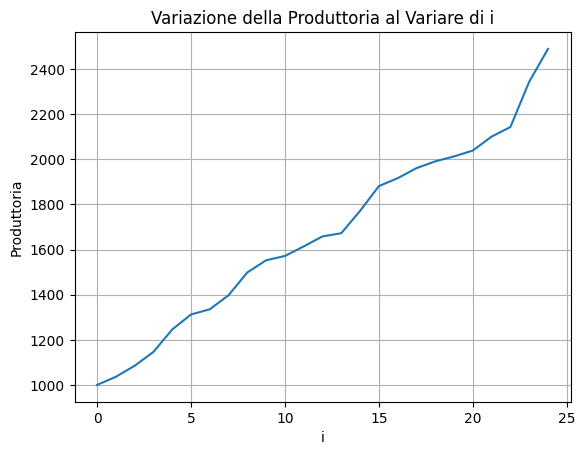

[1000,
 1036.0023979853538,
 1084.9337030913366,
 1146.296076577326,
 1245.8312299421086,
 1312.2590867969518,
 1335.2941167210004,
 1397.7566028331764,
 1498.9878721675716,
 1552.5909451554212,
 1571.6955268499667,
 1614.1030219454653,
 1658.4800045770905,
 1672.6396808099514,
 1771.7589887225004,
 1881.3507464550992,
 1916.41105627465,
 1961.0690614589157,
 1991.1376327278247,
 2012.955496393968,
 2039.0003675396856,
 2100.8845698399964,
 2143.3589845390084,
 2344.119186605251,
 2489.5410902609347]

In [31]:
# Inizializza la produttoria e la lista per memorizzare i valori
produttoria = 1000
valori = [produttoria]

# Calcola la produttoria per 100 volte
for i in range(1, 25):
    cas = random.uniform(1, 1.1)
    print(cas)
    produttoria *= cas
    valori.append(produttoria)

# Crea il grafico
plt.plot(valori)
plt.title('Variazione della Produttoria al Variare di i')
plt.xlabel('i')
plt.ylabel('Produttoria')
plt.grid()
plt.show()

valori

In [32]:
transazioni[-90:-30]

,Data,Numero giorno,Prezzo,Ultima Azione,Azione Attuale,% acquisto/vendita di LM,Quantità in € Comprata/Venduta,Quantità di Bitcoin Comprati/Venduti,Liquidità Mobile,Liquidità Fissa,Bitcoin Posseduti,Valore Totale del Portafoglio
95,2020-06-04,96,8642.152344,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1447.402851
96,2020-06-05,97,8560.423828,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1438.327047
97,2020-06-06,98,8549.510742,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1437.115169
98,2020-06-07,99,8621.272461,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1445.084178
99,2020-06-08,100,8644.083984,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1447.617356
100,2020-06-09,101,8643.343750,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1447.535154
101,2020-06-10,102,8683.817383,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1452.029678
102,2020-06-11,103,8257.708984,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1404.711113
103,2020-06-12,104,8422.061523,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1422.962165
104,2020-06-13,105,8418.423828,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1422.558205


In [33]:
def calcola_rendimento_portafoglio_ideale(capitale_iniziale, bitcoin_iniziali, lista_prezzi, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [34]:
rendimento_ideale, portafoglio_finale_ideale = calcola_rendimento_portafoglio_ideale(liquidita_mobile_iniziale+liquidita_fissa_iniziale, bitcoin_iniziali, dati['Price'], min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita)
print('Rendimento ideale:', rendimento_ideale)
print('Portafoglio finale ideale in euro:', portafoglio_finale_ideale)

Rendimento ideale: 10.014867303574043
Portafoglio finale ideale in euro: 10014.867303574043


In [35]:
valore_iniziale = liquidita_fissa_iniziale+liquidita_mobile_iniziale + bitcoin_iniziali * dati['Price'][0]
valore_finale = liquidita_mobile + bitcoin * dati['Price'].iloc[-1]
rendimento = valore_finale / valore_iniziale

In [36]:
print(f"Rendimento del portafoglio: {rendimento}")
print(f'Punteggio rendimento: {round(rendimento / rendimento_ideale *100, 2)}%')
print(f"Valore finale del portafoglio in euro: {liquidita_mobile + bitcoin * dati['Price'].iloc[-1]}")

Rendimento del portafoglio: 1.5217805621177982
Punteggio rendimento: 15.2%
Valore finale del portafoglio in euro: 1521.7805621177981


### Strategia 2: compravendita continua

In [ ]:
def calcola_percentuale_acquisto(prezzi, giorni, min_giorni_passati, denominatore_max_drawdown, 
                                 perc_acquisto_fisso):
    if len(prezzi) < min_giorni_passati:
        return perc_acquisto_fisso
    
    ultimi_giorni = prezzi[-giorni:]
    massimo = max(ultimi_giorni)
    minimo = min(ultimi_giorni)
    discesa_attuale = (ultimi_giorni.iloc[-2] - ultimi_giorni.iloc[-1]) / ultimi_giorni.iloc[-2]

    if denominatore_max_drawdown:
        max_drawdown = (massimo - minimo) / massimo
        if max_drawdown == 0:
            return perc_acquisto_fisso
        percentuale = discesa_attuale / max_drawdown
    else:
        max_discesa_due_giorni = max(
            [(ultimi_giorni.iloc[i] - ultimi_giorni.iloc[i + 1]) / ultimi_giorni.iloc[i] for i in range(len(ultimi_giorni) - 1)]
        )
        if max_discesa_due_giorni == 0:
            return perc_acquisto_fisso
        percentuale = discesa_attuale / max_discesa_due_giorni
    
    return min(1, percentuale)

def calcola_percentuale_vendita(prezzi, giorni, min_giorni_passati, denominatore_max_drawdown, 
                                perc_vendita_fisso):
    if len(prezzi) < min_giorni_passati:
        return perc_vendita_fisso
    
    ultimi_giorni = prezzi[-giorni:]
    massimo = max(ultimi_giorni)
    minimo = min(ultimi_giorni)
    salita_attuale = (ultimi_giorni.iloc[-1] - ultimi_giorni.iloc[-2]) / ultimi_giorni.iloc[-2]

    if denominatore_max_drawdown:
        max_drawdown = (massimo - minimo) / massimo
        if max_drawdown == 0:
            return perc_vendita_fisso
        percentuale = salita_attuale / max_drawdown
    else:
        max_salita_due_giorni = max(
            [(ultimi_giorni.iloc[i + 1] - ultimi_giorni.iloc[i]) / ultimi_giorni.iloc[i] for i in range(len(ultimi_giorni) - 1)]
        )
        if max_salita_due_giorni == 0:
            return perc_vendita_fisso
        percentuale = salita_attuale / max_salita_due_giorni
    
    return min(1, percentuale)

def strategia_trading(dati, giorni_acquisto, min_giorni_passati_acquisto, denominatore_acquisto_max_drawdown, 
                      usa_liquidita_iniziale, giorni_vendita, min_giorni_passati_vendita, 
                      denominatore_vendita_max_drawdown, liquidita_iniziale, token_iniziali,
                      perc_acquisto_fisso, perc_vendita_fisso, min_acquisto, min_vendita,
                      perc_commissione_acquisto, perc_commissione_vendita):

    liquidita = liquidita_iniziale
    token = token_iniziali
    portafoglio = []

    for i in range(1, len(dati)):
        prezzo_oggi = dati.iloc[i]
        prezzo_ieri = dati.iloc[i-1]
        
        # Decidere se comprare o vendere
        if prezzo_oggi < prezzo_ieri:
            percentuale_acquisto = calcola_percentuale_acquisto(
                dati.iloc[:i+1], giorni_acquisto, min_giorni_passati_acquisto, 
                denominatore_acquisto_max_drawdown, perc_acquisto_fisso
            )
            if usa_liquidita_iniziale:
                da_acquistare = liquidita_iniziale * percentuale_acquisto / prezzo_oggi
            else:
                da_acquistare = liquidita * percentuale_acquisto / prezzo_oggi
            
            costo_iniziale = da_acquistare * prezzo_oggi
            
            # Controllo se il costo iniziale senza commissioni supera la soglia minima di acquisto
            if costo_iniziale >= min_acquisto:
                costo_totale = costo_iniziale * (1 + perc_commissione_acquisto)
                if liquidita >= costo_totale:
                    token += da_acquistare
                    liquidita -= costo_totale

        elif prezzo_oggi > prezzo_ieri:
            percentuale_vendita = calcola_percentuale_vendita(
                dati.iloc[:i+1], giorni_vendita, min_giorni_passati_vendita, 
                denominatore_vendita_max_drawdown, perc_vendita_fisso
            )
            da_vendere = token * percentuale_vendita
            ricavo_iniziale = da_vendere * prezzo_oggi
            
            # Controllo se il ricavo iniziale senza commissioni supera la soglia minima di vendita
            if ricavo_iniziale >= min_vendita:
                ricavo_totale = ricavo_iniziale * (1 - perc_commissione_vendita)
                token -= da_vendere
                liquidita += ricavo_totale
        
        # Calcolo del valore del portafoglio
        valore_portafoglio = liquidita + token * prezzo_oggi
        portafoglio.append(valore_portafoglio)
    
    return portafoglio

In [ ]:
# Inizializzazione dei parametri fissi
liquidita_iniziale = 1000
bitcoin_iniziali = 0
perc_commissione_acquisto = 0.001
perc_commissione_vendita = 0.001
min_acquisto = 5
min_vendita = 5

# Inizializzazione dei parametri variabili (questi influenzano le metriche del trading)
giorni_acquisto = 5
min_giorni_passati_acquisto = 3
denominatore_acquisto_max_drawdown = False
usa_liquidita_iniziale = True
perc_acquisto_fisso = 0.05
giorni_vendita = 5
min_giorni_passati_vendita = 3
denominatore_vendita_max_drawdown = False
perc_vendita_fisso = 0.05

# Variabili per il tracciamento del portafoglio e delle transazioni
transazioni = pd.DataFrame(columns=['Data', 'Numero giorno', 'Prezzo', 'Ultima Azione', 'Azione Attuale', 
                                    '% acquisto/vendita di Liquidità', 'Quantità in € Comprata/Venduta', 
                                    'Quantità di Bitcoin Comprati/Venduti', 'Liquidità', 
                                    'Bitcoin Posseduti', 'Valore Totale del Portafoglio'])
giorni_acquisto = []
giorni_vendita = []

# Inizializzazione dello stato iniziale del portafoglio
liquidita_mobile = liquidita_iniziale
bitcoin = bitcoin_iniziali

# Funzione per aggiornare il DataFrame delle transazioni
def aggiorna_transazioni(i, azione, perc, quantita_euro, quantita_btc):
    global transazioni, liquidita_mobile, bitcoin
    nuova_transazione = pd.DataFrame({
        'Data': [dati['Timestamp'].iloc[i]],
        'Numero giorno': i,
        'Prezzo': [dati['Price'].iloc[i]],
        'Ultima Azione': [transazioni['Azione Attuale'].iloc[-1] if not transazioni.empty else "-"],
        'Azione Attuale': [azione],
        '% acquisto/vendita di Liquidità': [perc],
        'Quantità in € Comprata/Venduta': [quantita_euro],
        'Quantità di Bitcoin Comprati/Venduti': [quantita_btc],
        'Liquidità': [liquidita_mobile],
        'Bitcoin Posseduti': [bitcoin],
        'Valore Totale del Portafoglio': [liquidita_mobile + bitcoin * dati['Price'].iloc[i]]
    })
    transazioni = pd.concat([transazioni, nuova_transazione], ignore_index=True)

# Esecuzione della strategia di trading
valori_portafoglio = strategia_trading(
    dati['Price'], giorni_acquisto, min_giorni_passati_acquisto, denominatore_acquisto_max_drawdown, 
    usa_liquidita_iniziale, giorni_vendita, min_giorni_passati_vendita, 
    denominatore_vendita_max_drawdown, liquidita_iniziale, bitcoin_iniziali,
    perc_acquisto_fisso, perc_vendita_fisso, min_acquisto, min_vendita, 
    perc_commissione_acquisto, perc_commissione_vendita
)

# Aggiorna le transazioni in base al portafoglio risultante
for i in range(1, len(dati)):
    prezzo_oggi = dati['Price'].iloc[i]
    valore_portafoglio_oggi = liquidita_mobile + bitcoin * prezzo_oggi
    aggiorna_transazioni(i, "-", 0, 0, 0)  # Se non c'è stata azione, aggiorniamo comunque

# Preparazione dei dati per il grafico
acquisti = transazioni[transazioni['Azione Attuale'].isin(['Acquisto'])]
vendite = transazioni[transazioni['Azione Attuale'].isin(['Vendita'])]

# Calcolo delle dimensioni dei punti per il grafico
max_acquisto = acquisti['Quantità in € Comprata/Venduta'].max()
max_vendita = vendite['Quantità in € Comprata/Venduta'].max()

def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
    return min_size + (max_size - min_size) * (quantita / max_quantita)

dimensioni_acquisti = acquisti['Quantità in € Comprata/Venduta'].apply(lambda x: calcola_dimensione(x, max_acquisto))
dimensioni_vendite = vendite['Quantità in € Comprata/Venduta'].apply(lambda x: calcola_dimensione(x, max_vendita))

# Creazione del grafico delle transazioni
plt.figure(figsize=(20, 14))
plt.grid()
plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
if not acquisti.empty:
    plt.scatter(acquisti['Data'], acquisti['Prezzo'], s=dimensioni_acquisti, color='green', alpha=0.6, label='Acquisti')
    for i, row in acquisti.iterrows():
        plt.text(row['Data'], row['Prezzo'], f"+{row['Quantità in € Comprata/Venduta']:.2f} €", 
                 color='black', ha='center', va='bottom')
if not vendite.empty:
    plt.scatter(vendite['Data'], vendite['Prezzo'], s=dimensioni_vendite, color='red', alpha=0.6, label='Vendite')
    for i, row in vendite.iterrows():
        plt.text(row['Data'], row['Prezzo'], f"-{row['Quantità in € Comprata/Venduta']:.2f} €", 
                 color='black', ha='center', va='top')

plt.xlabel('Data')
plt.ylabel('Prezzo')
plt.title('Andamento dei prezzi e transazioni')
plt.legend()
plt.show()

# Grafico del valore totale del portafoglio nel tempo
plt.figure(figsize=(20, 7))
plt.plot(dati['Timestamp'][1:], valori_portafoglio, label='Valore Totale del Portafoglio')
plt.xlabel('Data')
plt.ylabel('Valore Totale del Portafoglio')
plt.title('Andamento del Valore del Portafoglio nel Tempo')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
transazioni['Liquidità Fissa']

0      0
1      0
2      0
3      0
4      0
      ..
180    0
181    0
182    0
183    0
184    0
Name: Liquidità Fissa, Length: 185, dtype: object

In [ ]:
# valori_portafoglio.insert(0, liquidita_fissa_iniziale+liquidita_mobile_iniziale)
# valori_portafoglio

In [ ]:
# rapporti_valori_portafoglio.insert(0, valori_portafoglio[1]/(valori_portafoglio[0]))
# rapporti_valori_portafoglio

In [ ]:
# np.mean(rapporti_valori_portafoglio)

In [ ]:
# np.std(rapporti_valori_portafoglio)

1.0360023979853539
1.04723088016122
1.0565586388469153
1.0868319759603298
1.053320108902656
1.017553721026443
1.0467780733323093
1.0724241038312428
1.035759510789329
1.0123049678694558
1.0269820040656938
1.027493277707973
1.008537743110428
1.0592592110839747
1.0618547773315479
1.0186357115416211
1.0233029365166977
1.0153327447053495
1.0109574864678004
1.012938622434711
1.0303502653974417
1.020217395714533
1.0936661583591056
1.0620369068632058


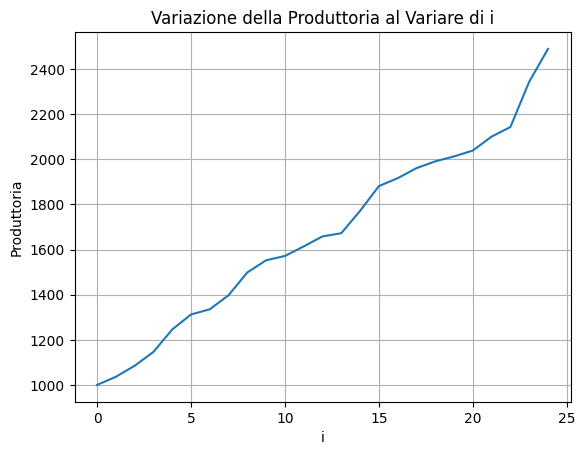

[1000,
 1036.0023979853538,
 1084.9337030913366,
 1146.296076577326,
 1245.8312299421086,
 1312.2590867969518,
 1335.2941167210004,
 1397.7566028331764,
 1498.9878721675716,
 1552.5909451554212,
 1571.6955268499667,
 1614.1030219454653,
 1658.4800045770905,
 1672.6396808099514,
 1771.7589887225004,
 1881.3507464550992,
 1916.41105627465,
 1961.0690614589157,
 1991.1376327278247,
 2012.955496393968,
 2039.0003675396856,
 2100.8845698399964,
 2143.3589845390084,
 2344.119186605251,
 2489.5410902609347]

In [ ]:
# Inizializza la produttoria e la lista per memorizzare i valori
produttoria = 1000
valori = [produttoria]

# Calcola la produttoria per 100 volte
for i in range(1, 25):
    cas = random.uniform(1, 1.1)
    print(cas)
    produttoria *= cas
    valori.append(produttoria)

# Crea il grafico
plt.plot(valori)
plt.title('Variazione della Produttoria al Variare di i')
plt.xlabel('i')
plt.ylabel('Produttoria')
plt.grid()
plt.show()

valori

In [ ]:
transazioni[-90:-30]

,Data,Numero giorno,Prezzo,Ultima Azione,Azione Attuale,% acquisto/vendita di LM,Quantità in € Comprata/Venduta,Quantità di Bitcoin Comprati/Venduti,Liquidità Mobile,Liquidità Fissa,Bitcoin Posseduti,Valore Totale del Portafoglio
95,2020-06-04,96,8642.152344,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1447.402851
96,2020-06-05,97,8560.423828,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1438.327047
97,2020-06-06,98,8549.510742,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1437.115169
98,2020-06-07,99,8621.272461,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1445.084178
99,2020-06-08,100,8644.083984,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1447.617356
100,2020-06-09,101,8643.343750,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1447.535154
101,2020-06-10,102,8683.817383,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1452.029678
102,2020-06-11,103,8257.708984,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1404.711113
103,2020-06-12,104,8422.061523,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1422.962165
104,2020-06-13,105,8418.423828,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1422.558205


In [ ]:
def calcola_rendimento_portafoglio_ideale(capitale_iniziale, bitcoin_iniziali, lista_prezzi, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [ ]:
rendimento_ideale, portafoglio_finale_ideale = calcola_rendimento_portafoglio_ideale(liquidita_mobile_iniziale+liquidita_fissa_iniziale, bitcoin_iniziali, dati['Price'], min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita)
print('Rendimento ideale:', rendimento_ideale)
print('Portafoglio finale ideale in euro:', portafoglio_finale_ideale)

Rendimento ideale: 10.014867303574043
Portafoglio finale ideale in euro: 10014.867303574043


In [ ]:
valore_iniziale = liquidita_fissa_iniziale+liquidita_mobile_iniziale + bitcoin_iniziali * dati['Price'][0]
valore_finale = liquidita_mobile + bitcoin * dati['Price'].iloc[-1]
rendimento = valore_finale / valore_iniziale

In [ ]:
print(f"Rendimento del portafoglio: {rendimento}")
print(f'Punteggio rendimento: {round(rendimento / rendimento_ideale *100, 2)}%')
print(f"Valore finale del portafoglio in euro: {liquidita_mobile + bitcoin * dati['Price'].iloc[-1]}")

Rendimento del portafoglio: 1.5217805621177982
Punteggio rendimento: 15.2%
Valore finale del portafoglio in euro: 1521.7805621177981


## Generazione dataset sintetici

In [37]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [38]:
# dati = pd.read_csv('Bitcoin (€) da yfinance dal 06-05-2022 alle 21 al 05-05-2024 alle 19 con granularità oraria.csv')
# dati = dati[['Datetime', 'Close']]
# dati = dati.rename(columns = {'Datetime':'Timestamp', 'Close': 'Price'})
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
# dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d %H')
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d %H')
# dati

In [39]:
data_inizio = '2021-01-09'
data_fine = '2023-12-03'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2021-01-09,32928.058594
1,2021-01-10,31472.685547
2,2021-01-11,29247.208984
3,2021-01-12,27786.228516
4,2021-01-13,30682.929688
...,...,...
1054,2023-11-29,34379.074219
1055,2023-11-30,34499.992188
1056,2023-12-01,34625.015625
1057,2023-12-02,35518.437500


In [40]:
# data_inizio = '2023-06-01 00'
# data_fine = '2023-12-01 00'
# indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
# indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
# dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
# dati

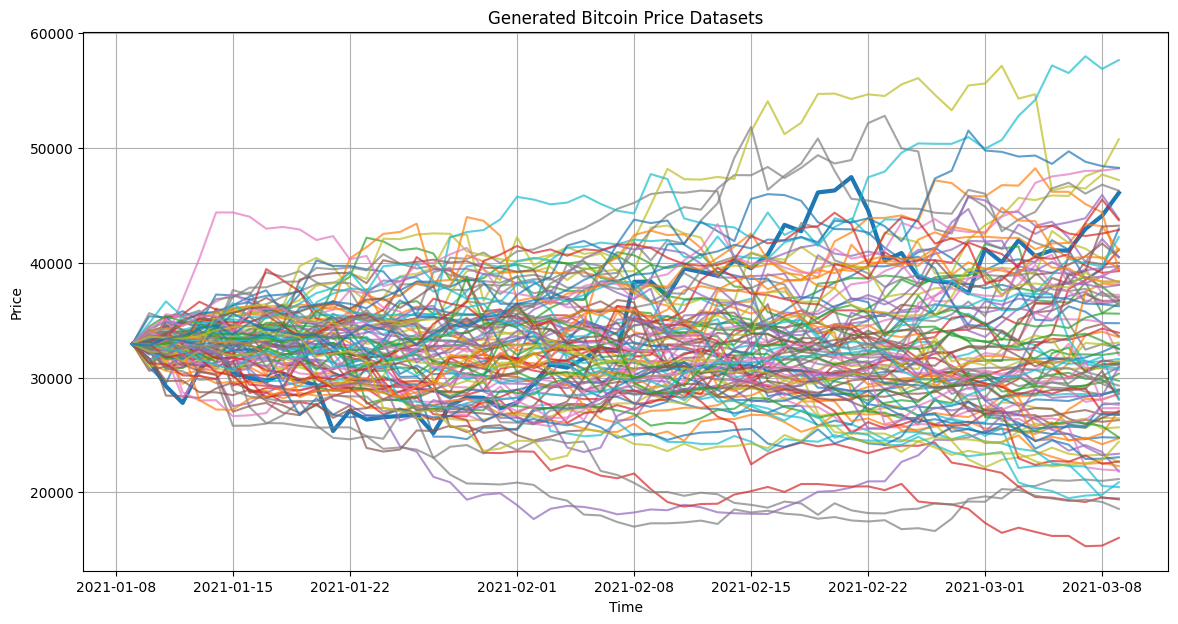

In [41]:
# Calcola le variazioni giornaliere
dati['Daily Change'] = dati['Price'].pct_change().dropna()

# Estrai la distribuzione delle variazioni giornaliere
daily_changes = dati['Daily Change'].values[1:]

# Numero di dataset da generare
n_dataset = 100

# Numero di giorni che dura ogni dataset
lunghezza_dataset = 60

# Fissa il random_state
random_state = 42
np.random.seed(random_state)

# Lista per conservare i dataset generati
generated_datasets = []

# Genera i dataset
for i in range(n_dataset):
    generated_prices = [dati['Price'].iloc[0]]  # Il primo prezzo coincide con il primo dato originale
    for _ in range(lunghezza_dataset - 1):
        change = np.random.choice(daily_changes)
        new_price = generated_prices[-1] * (1 + change)
        generated_prices.append(new_price)
    generated_datasets.append(generated_prices)

# Converte i dataset generati in DataFrame
generated_dfs = [pd.DataFrame({'Timestamp': dati['Timestamp'].iloc[:lunghezza_dataset], 'Price': prices}) for prices in generated_datasets]

# Plotting
plt.figure(figsize=(14, 7))

# Plot del dataset originale
plt.plot(dati['Timestamp'].iloc[:lunghezza_dataset], dati['Price'].iloc[:lunghezza_dataset].values, label='Original', linewidth=3)

# Plot dei dataset generati
for i, df in enumerate(generated_dfs):
    plt.plot(df['Timestamp'], df['Price'], label=f'Generated Dataset {i+1}', alpha=0.7)

plt.title('Generated Bitcoin Price Datasets')
plt.xlabel('Time')
plt.ylabel('Price')
# plt.yscale('log')
plt.grid()
# plt.legend()
plt.show()

In [42]:
# Crea un DataFrame combinato
combined_df = pd.DataFrame()
combined_df['Timestamp'] = dati['Timestamp'].iloc[:lunghezza_dataset]
for i, prices in enumerate(generated_datasets):
    combined_df[f'Generated Dataset {i+1}'] = prices

# Salva il DataFrame combinato in un file CSV
# combined_df.to_csv('generated_datasets_09_01_2021_03_12_2023_60.csv', index=False)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\2406152257.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[f'Generated Dataset {i+1}'] = prices


In [43]:
print('Fattore di ritorno medio dei prezzi generati:', np.mean([df['Price'].iloc[-1] / df['Price'].iloc[0] for df in generated_dfs]))

ideal_returns = [calcola_rendimento_portafoglio_ideale(1000, 0, df['Price'], 5, 5, 0.001, 0.001)[0] for df in generated_dfs]

print('Media dei fattori di rendimento massimi ottenibili:', np.mean(ideal_returns))

Fattore di ritorno medio dei prezzi generati: 0.9938671717603585
Media dei fattori di rendimento massimi ottenibili: 1.8615805945919237


In [44]:
# Leggi il file CSV
loaded_df = pd.read_csv('generated_datasets_09_01_2021_03_12_2023_60.csv')

# Lista per conservare i dataset letti
read_dfs = []

# Separazione dei dataset dal DataFrame caricato
for column in loaded_df.columns[1:]:  # Ignora la colonna 'Timestamp'
    df = pd.DataFrame({
        'Timestamp': loaded_df['Timestamp'],
        'Price': loaded_df[column]
    })
    read_dfs.append(df)

# Controllo del primo dataset per verificare
read_dfs[0]

,Timestamp,Price
0,2021-01-09,32928.058594
1,2021-01-10,32867.007988
2,2021-01-11,33622.276971
3,2021-01-12,34120.684437
4,2021-01-13,33468.657388
5,2021-01-14,34353.574928
6,2021-01-15,33092.814400
7,2021-01-16,32964.017763
8,2021-01-17,36168.925059
9,2021-01-18,36280.266798


## Testo il mio algoritmo di trading sui dataset generati

### Seleziono solo il periodo che voglio

In [45]:
# data_inizio = '2020-02-29'
# data_fine = '2020-09-01'
# indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
# indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
# for i in range(len(generated_dfs)):
#     generated_dfs[i] = generated_dfs[i][indice_inizio:indice_fine + 1].reset_index(drop=True)

# generated_dfs[0]

In [46]:
# dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
# dati

### Visualizzo i dati nel nuovo periodo selezionato

In [47]:
# # Plotting
# plt.figure(figsize=(14, 7))

# # Plot del dataset originale
# plt.plot(dati['Price'].values, label='Original', linewidth=3)

# # Plot dei dataset generati
# for i, df in enumerate(generated_dfs):
#     plt.plot(df['Price'].values, label=f'Generated Dataset {i+1}', alpha=0.7)

# plt.title('Generated Bitcoin Price Datasets')
# plt.xlabel('Time')
# plt.ylabel('Price')
# plt.yscale('log')
# plt.grid()
# # plt.legend()
# plt.show()

### Strategia di trading

#### Strategia con variabili statiche

In [48]:
# Supponiamo che la tua funzione di trading sia implementata come `trading_strategy`
def trading_strategy(dati, liquidita_mobile_iniziale, liquidita_fissa_iniziale, bitcoin_iniziali, perc_primo_acquisto, vendita_immediata, perc_sbilanciamento_acquisto, perc_commissione_acquisto, perc_commissione_vendita, min_acquisto, min_vendita, soglia_minima_acquisto, soglia_minima_vendita, perc_stop_loss, compra_pure):

    liquidita_mobile = liquidita_mobile_iniziale
    liquidita_fissa = liquidita_fissa_iniziale
    bitcoin = bitcoin_iniziali

    ultima_azione_effettiva = None
    ultimi_acquisti = []
    transazioni = pd.DataFrame(columns=['Data', 'Numero giorno', 'Prezzo', 'Ultima Azione', 'Azione Attuale', '% acquisto/vendita di LM', 'Quantità in € Comprata/Venduta', 'Quantità di Bitcoin Comprati/Venduti', 'Liquidità Mobile', 'Liquidità Fissa', 'Bitcoin Posseduti', 'Valore Totale del Portafoglio'])
    giorni_acquisto = []
    giorni_vendita = []

    prezzo_massimo = 0
    in_salita = False

    def aggiorna_transazioni(i, azione, perc, quantita_euro, quantita_btc):
        nonlocal transazioni, liquidita_mobile, liquidita_fissa, bitcoin, ultima_azione_effettiva # La parola chiave nonlocal viene utilizzata per dichiarare che una variabile all'interno di una funzione nidificata (una funzione definita all'interno di un'altra funzione) si riferisce a una variabile definita nel contesto della funzione esterna (non globale, ma nemmeno locale alla funzione corrente); dovrei usare invece "global" se questa function fosse definita a livello globale e non all'interno di un'altra function
        ultima_azione = ultima_azione_effettiva if ultima_azione_effettiva else "-"
        nuova_transazione = pd.DataFrame({
            'Data': [dati['Timestamp'].iloc[i]],
            'Numero giorno': i,
            'Prezzo': [dati['Price'].iloc[i]],
            'Ultima Azione': [ultima_azione],
            'Azione Attuale': [azione],
            '% acquisto/vendita di LM': [perc],
            'Quantità in € Comprata/Venduta': [quantita_euro],
            'Quantità di Bitcoin Comprati/Venduti': [quantita_btc],
            'Liquidità Mobile': [liquidita_mobile],
            'Liquidità Fissa': [liquidita_fissa],
            'Bitcoin Posseduti': [bitcoin],
            'Valore Totale del Portafoglio': [liquidita_mobile + liquidita_fissa + bitcoin * dati['Price'].iloc[i]]
        })
        transazioni = pd.concat([transazioni, nuova_transazione], ignore_index=True)
        if azione != "-":
            ultima_azione_effettiva = azione

    def primo_acquisto(i):
        nonlocal liquidita_mobile, bitcoin, ultimi_acquisti
        quantita_primo_acquisto = liquidita_mobile * perc_primo_acquisto
        bitcoin_acquistati = quantita_primo_acquisto / dati['Price'].iloc[i] * (1 - perc_commissione_acquisto)
        liquidita_mobile -= quantita_primo_acquisto
        bitcoin += bitcoin_acquistati
        ultimi_acquisti = [(dati['Price'].iloc[i], quantita_primo_acquisto)]
        giorni_acquisto.append(i)
        aggiorna_transazioni(i, 'Primo Acquisto', perc_primo_acquisto, quantita_primo_acquisto, bitcoin_acquistati)

    def calcola_prezzo_medio_pesato():
        return sum([euro*prezzo for prezzo, euro in ultimi_acquisti]) / sum([euro for _ , euro in ultimi_acquisti])

    # Primo acquisto al giorno 1
    primo_acquisto(1)

    for i in range(2, len(dati)):
        prezzo_oggi = dati['Price'].iloc[i]
        prezzo_ieri = dati['Price'].iloc[i-1]
        prezzo_laltro_ieri = dati['Price'].iloc[i-2]
        azione = "-"  # Inizializziamo l'azione come nulla
        
        if bitcoin > 0:
            prezzo_medio_pesato = calcola_prezzo_medio_pesato()
            
            # Aggiorna il prezzo massimo se siamo in una salita
            if prezzo_oggi > prezzo_ieri:
                in_salita = True
                if prezzo_ieri < prezzo_laltro_ieri:
                    prezzo_massimo = 0  # Reset del prezzo massimo se il giorno precedente è finita una discesa
                prezzo_massimo = max(prezzo_massimo, prezzo_oggi)
            else:
                in_salita = False
            
            if vendita_immediata:
                if prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
                    # Vendita immediata
                    quantita_venduta = bitcoin
                    ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
                    if ricavo >= min_vendita:
                        liquidita_mobile += ricavo
                        bitcoin = 0
                        giorni_vendita.append(i)
                        azione = 'Vendita'
                        aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
                        # print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]))
                        ultimi_acquisti = []
            else:
                if not in_salita and prezzo_oggi <= prezzo_massimo * (1 - perc_stop_loss) and prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
                    # Vendita con stop-loss
                    quantita_venduta = bitcoin
                    ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
                    if ricavo >= min_vendita:
                        liquidita_mobile += ricavo
                        bitcoin = 0
                        giorni_vendita.append(i)
                        azione = 'Vendita (Stop-Loss)'
                        aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
                        # print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]), bitcoin*dati['Price'].iloc[i] + liquidita_mobile + liquidita_fissa)
                        ultimi_acquisti = []
        
        if azione != 'Vendita' and azione != 'Vendita (Stop-Loss)':  # Se non abbiamo venduto, consideriamo l'acquisto
            if not ultimi_acquisti:
                if prezzo_oggi < prezzo_ieri:
                    # Primo acquisto dopo una vendita
                    primo_acquisto(i)
                    azione = 'Primo Acquisto'
                    # prezzo_massimo = prezzo_oggi  # Inizializzo il prezzo massimo
            elif prezzo_oggi < ultimi_acquisti[-1][0] * (1 - soglia_minima_acquisto):
                # Calcolo del prezzo desiderato di acquisto
                ultimo_prezzo_acquisto = ultimi_acquisti[-1][0]
                A = perc_sbilanciamento_acquisto * prezzo_oggi + (1 - perc_sbilanciamento_acquisto) * ultimo_prezzo_acquisto # Prezzo a cui si vuole imporre la media pesata

                # Calcolo della quantità da acquistare
                S = sum([p * q for p, q in ultimi_acquisti])  # Questa è la somma pesata degli ultimi acquisti
                P = sum([q for _, q in ultimi_acquisti])  # Questa è la somma delle spese degli ultimi acquisti, cioè la somma dei pesi
                quantita_da_acquistare_euro = (S - A * P) / (A - prezzo_oggi)

                if quantita_da_acquistare_euro >= min_acquisto:
                    if quantita_da_acquistare_euro > liquidita_mobile:
                        # Usa la liquidità fissa se necessario
                        liquidita_aggiuntiva = min(liquidita_fissa, quantita_da_acquistare_euro - liquidita_mobile)
                        liquidita_mobile += liquidita_aggiuntiva
                        liquidita_fissa -= liquidita_aggiuntiva

                    if quantita_da_acquistare_euro <= liquidita_mobile:
                        # Acquisto
                        bitcoin_acquistati = quantita_da_acquistare_euro / prezzo_oggi * (1 - perc_commissione_acquisto)
                        vecchia_liquidita_mobile = liquidita_mobile
                        liquidita_mobile -= quantita_da_acquistare_euro
                        bitcoin += bitcoin_acquistati
                        ultimi_acquisti.append((prezzo_oggi, quantita_da_acquistare_euro))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
                        giorni_acquisto.append(i)
                        azione = 'Acquisto'
                        aggiorna_transazioni(i, azione, quantita_da_acquistare_euro / vecchia_liquidita_mobile, quantita_da_acquistare_euro, bitcoin_acquistati)

                    elif quantita_da_acquistare_euro > liquidita_mobile and compra_pure and liquidita_mobile != 0:
                        # Acquisto con tutto quello che rimane nella liquidità mobile anche se non viene rispettata la percentuale di sbilanciamento richiesta
                        bitcoin_acquistati = liquidita_mobile / prezzo_oggi * (1 - perc_commissione_acquisto)
                        vecchia_liquidita_mobile = liquidita_mobile
                        liquidita_mobile = 0
                        bitcoin += bitcoin_acquistati
                        ultimi_acquisti.append((prezzo_oggi, vecchia_liquidita_mobile))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
                        giorni_acquisto.append(i)
                        azione = 'Acquisto'
                        aggiorna_transazioni(i, azione, 1, vecchia_liquidita_mobile, bitcoin_acquistati)
        
        if azione == "-":
            # Se non è stata effettuata nessuna azione, aggiungo comunque una riga alla tabella
            aggiorna_transazioni(i, azione, 0, 0, 0)

    return transazioni

#### Strategia con variabili dinamiche

In [49]:
# Supponiamo che la tua funzione di trading sia implementata come `trading_strategy`
def trading_strategy_modified(dati, liquidita_mobile_iniziale, liquidita_fissa_iniziale, bitcoin_iniziali, perc_primo_acquisto, vendita_immediata, perc_sbilanciamento_acquisto, perc_commissione_acquisto, perc_commissione_vendita, min_acquisto, min_vendita, soglia_minima_acquisto, soglia_minima_vendita, perc_stop_loss, compra_pure, vendita_immediata_dinamica, tempo_rsi, soglia_rsi):

    liquidita_mobile = liquidita_mobile_iniziale
    liquidita_fissa = liquidita_fissa_iniziale
    bitcoin = bitcoin_iniziali

    ultima_azione_effettiva = None
    ultimi_acquisti = []
    transazioni = pd.DataFrame(columns=['Data', 'Numero giorno', 'Prezzo', 'Ultima Azione', 'Azione Attuale', '% acquisto/vendita di LM', 'Quantità in € Comprata/Venduta', 'Quantità di Bitcoin Comprati/Venduti', 'Liquidità Mobile', 'Liquidità Fissa', 'Bitcoin Posseduti', 'Valore Totale del Portafoglio'])
    giorni_acquisto = []
    giorni_vendita = []

    prezzo_massimo = 0
    in_salita = False

    def aggiorna_transazioni(i, azione, perc, quantita_euro, quantita_btc):
        nonlocal transazioni, liquidita_mobile, liquidita_fissa, bitcoin, ultima_azione_effettiva # La parola chiave nonlocal viene utilizzata per dichiarare che una variabile all'interno di una funzione nidificata (una funzione definita all'interno di un'altra funzione) si riferisce a una variabile definita nel contesto della funzione esterna (non globale, ma nemmeno locale alla funzione corrente); dovrei usare invece "global" se questa function fosse definita a livello globale e non all'interno di un'altra function
        ultima_azione = ultima_azione_effettiva if ultima_azione_effettiva else "-"
        nuova_transazione = pd.DataFrame({
            'Data': [dati['Timestamp'].iloc[i]],
            'Numero giorno': i,
            'Prezzo': [dati['Price'].iloc[i]],
            'Ultima Azione': [ultima_azione],
            'Azione Attuale': [azione],
            '% acquisto/vendita di LM': [perc],
            'Quantità in € Comprata/Venduta': [quantita_euro],
            'Quantità di Bitcoin Comprati/Venduti': [quantita_btc],
            'Liquidità Mobile': [liquidita_mobile],
            'Liquidità Fissa': [liquidita_fissa],
            'Bitcoin Posseduti': [bitcoin],
            'Valore Totale del Portafoglio': [liquidita_mobile + liquidita_fissa + bitcoin * dati['Price'].iloc[i]]
        })
        transazioni = pd.concat([transazioni, nuova_transazione], ignore_index=True)
        if azione != "-":
            ultima_azione_effettiva = azione

    def primo_acquisto(i):
        nonlocal liquidita_mobile, bitcoin, ultimi_acquisti
        quantita_primo_acquisto = liquidita_mobile * perc_primo_acquisto
        bitcoin_acquistati = quantita_primo_acquisto / dati['Price'].iloc[i] * (1 - perc_commissione_acquisto)
        liquidita_mobile -= quantita_primo_acquisto
        bitcoin += bitcoin_acquistati
        ultimi_acquisti = [(dati['Price'].iloc[i], quantita_primo_acquisto)]
        giorni_acquisto.append(i)
        aggiorna_transazioni(i, 'Primo Acquisto', perc_primo_acquisto, quantita_primo_acquisto, bitcoin_acquistati)

    def calcola_prezzo_medio_pesato():
        return sum([euro*prezzo for prezzo, euro in ultimi_acquisti]) / sum([euro for _ , euro in ultimi_acquisti])
    
    def calculate_rsi(prices):
        if len(prices) < 2:
            raise ValueError("La lista dei prezzi deve contenere almeno 2 elementi per calcolare l'RSI.")

        # Calcola le variazioni di prezzo
        price_changes = [prices.iloc[k] - prices.iloc[k-1] for k in range(1, len(prices))]
        
        # Separa i guadagni e le perdite
        gains = [max(change, 0) for change in price_changes]
        losses = [abs(min(change, 0)) for change in price_changes]

        # Calcola la media dei guadagni e delle perdite
        avg_gain = sum(gains) / len(gains) if len(gains) != 0 else 0
        avg_loss = sum(losses) / len(losses) if len(losses) != 0 else 0

        rsi = 100 * avg_gain / (avg_gain + avg_loss)

        return rsi

    # Primo acquisto al giorno 1
    primo_acquisto(1)

    for i in range(2, len(dati)):
        if vendita_immediata_dinamica:
            if i < tempo_rsi:
                dati_parziali = dati[:i]
            else:
                dati_parziali = dati[i-tempo_rsi:i]

            rsi = calculate_rsi(dati_parziali['Price'])

            if rsi > soglia_rsi:
                vendita_immediata = False
            else:
                vendita_immediata = True

        prezzo_oggi = dati['Price'].iloc[i]
        prezzo_ieri = dati['Price'].iloc[i-1]
        prezzo_laltro_ieri = dati['Price'].iloc[i-2]
        azione = "-"  # Inizializziamo l'azione come nulla
        
        if bitcoin > 0:
            prezzo_medio_pesato = calcola_prezzo_medio_pesato()
            
            # Aggiorna il prezzo massimo se siamo in una salita
            if prezzo_oggi > prezzo_ieri:
                in_salita = True
                if prezzo_ieri < prezzo_laltro_ieri:
                    prezzo_massimo = 0  # Reset del prezzo massimo se il giorno precedente è finita una discesa
                prezzo_massimo = max(prezzo_massimo, prezzo_oggi)
            else:
                in_salita = False
            
            if vendita_immediata:
                if prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
                    # Vendita immediata
                    quantita_venduta = bitcoin
                    ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
                    if ricavo >= min_vendita:
                        liquidita_mobile += ricavo
                        bitcoin = 0
                        giorni_vendita.append(i)
                        azione = 'Vendita'
                        aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
                        # print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]))
                        ultimi_acquisti = []
            else:
                if not in_salita and prezzo_oggi <= prezzo_massimo * (1 - perc_stop_loss) and prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
                    # Vendita con stop-loss
                    quantita_venduta = bitcoin
                    ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
                    if ricavo >= min_vendita:
                        liquidita_mobile += ricavo
                        bitcoin = 0
                        giorni_vendita.append(i)
                        azione = 'Vendita (Stop-Loss)'
                        aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
                        # print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]), bitcoin*dati['Price'].iloc[i] + liquidita_mobile + liquidita_fissa)
                        ultimi_acquisti = []
        
        if azione != 'Vendita' and azione != 'Vendita (Stop-Loss)':  # Se non abbiamo venduto, consideriamo l'acquisto
            if not ultimi_acquisti:
                if prezzo_oggi < prezzo_ieri:
                    # Primo acquisto dopo una vendita
                    primo_acquisto(i)
                    azione = 'Primo Acquisto'
                    # prezzo_massimo = prezzo_oggi  # Inizializzo il prezzo massimo
            elif prezzo_oggi < ultimi_acquisti[-1][0] * (1 - soglia_minima_acquisto):
                # Calcolo del prezzo desiderato di acquisto
                ultimo_prezzo_acquisto = ultimi_acquisti[-1][0]
                A = perc_sbilanciamento_acquisto * prezzo_oggi + (1 - perc_sbilanciamento_acquisto) * ultimo_prezzo_acquisto # Prezzo a cui si vuole imporre la media pesata

                # Calcolo della quantità da acquistare
                S = sum([p * q for p, q in ultimi_acquisti])  # Questa è la somma pesata degli ultimi acquisti
                P = sum([q for _, q in ultimi_acquisti])  # Questa è la somma delle spese degli ultimi acquisti, cioè la somma dei pesi
                quantita_da_acquistare_euro = (S - A * P) / (A - prezzo_oggi)

                if quantita_da_acquistare_euro >= min_acquisto:
                    if quantita_da_acquistare_euro > liquidita_mobile:
                        # Usa la liquidità fissa se necessario
                        liquidita_aggiuntiva = min(liquidita_fissa, quantita_da_acquistare_euro - liquidita_mobile)
                        liquidita_mobile += liquidita_aggiuntiva
                        liquidita_fissa -= liquidita_aggiuntiva

                    if quantita_da_acquistare_euro <= liquidita_mobile:
                        # Acquisto
                        bitcoin_acquistati = quantita_da_acquistare_euro / prezzo_oggi * (1 - perc_commissione_acquisto)
                        vecchia_liquidita_mobile = liquidita_mobile
                        liquidita_mobile -= quantita_da_acquistare_euro
                        bitcoin += bitcoin_acquistati
                        ultimi_acquisti.append((prezzo_oggi, quantita_da_acquistare_euro))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
                        giorni_acquisto.append(i)
                        azione = 'Acquisto'
                        aggiorna_transazioni(i, azione, quantita_da_acquistare_euro / vecchia_liquidita_mobile, quantita_da_acquistare_euro, bitcoin_acquistati)

                    elif quantita_da_acquistare_euro > liquidita_mobile and compra_pure and liquidita_mobile != 0:
                        # Acquisto con tutto quello che rimane nella liquidità mobile anche se non viene rispettata la percentuale di sbilanciamento richiesta
                        bitcoin_acquistati = liquidita_mobile / prezzo_oggi * (1 - perc_commissione_acquisto)
                        vecchia_liquidita_mobile = liquidita_mobile
                        liquidita_mobile = 0
                        bitcoin += bitcoin_acquistati
                        ultimi_acquisti.append((prezzo_oggi, vecchia_liquidita_mobile))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
                        giorni_acquisto.append(i)
                        azione = 'Acquisto'
                        aggiorna_transazioni(i, azione, 1, vecchia_liquidita_mobile, bitcoin_acquistati)
        
        if azione == "-":
            # Se non è stata effettuata nessuna azione, aggiungo comunque una riga alla tabella
            aggiorna_transazioni(i, azione, 0, 0, 0)

    return transazioni

In [50]:
generated_dfs[0]

,Timestamp,Price
0,2021-01-09,32928.058594
1,2021-01-10,32867.007988
2,2021-01-11,33622.276971
3,2021-01-12,34120.684437
4,2021-01-13,33468.657388
5,2021-01-14,34353.574928
6,2021-01-15,33092.814400
7,2021-01-16,32964.017763
8,2021-01-17,36168.925059
9,2021-01-18,36280.266798


In [51]:
read_dfs[0]

,Timestamp,Price
0,2021-01-09,32928.058594
1,2021-01-10,32867.007988
2,2021-01-11,33622.276971
3,2021-01-12,34120.684437
4,2021-01-13,33468.657388
5,2021-01-14,34353.574928
6,2021-01-15,33092.814400
7,2021-01-16,32964.017763
8,2021-01-17,36168.925059
9,2021-01-18,36280.266798


In [52]:
dati_da_usare = read_dfs.copy()

In [53]:
# Funzione per calcolare il Max Drawdown
def max_drawdown(portfolio_values):
    peak = portfolio_values.cummax()
    drawdown = (portfolio_values - peak) / peak
    max_dd = drawdown.min()
    return max_dd

# Funzione per calcolare lo Sharpe Ratio
def sharpe_ratio(portfolio_returns, risk_free_rate=0.0):
    excess_returns = portfolio_returns - risk_free_rate
    return excess_returns.mean() / excess_returns.std()

# Funzione per calcolare il Sortino Ratio
def sortino_ratio(portfolio_returns, risk_free_rate=0.0):
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std = downside_returns.std()
    return (portfolio_returns.mean() - risk_free_rate) / downside_std

# Funzione per calcolare il Calmar Ratio
def calmar_ratio(portfolio_returns, max_drawdown_value):
    annual_return = portfolio_returns.mean() * 252  # 252 è il numero medio di giorni di trading in un anno
    return annual_return / abs(max_drawdown_value)

# Parametri fissi
liquidita_mobile_iniziale = 1000
liquidita_fissa_iniziale = 0
bitcoin_iniziali = 0
min_acquisto = 5
min_vendita = 5
perc_commissione_acquisto = 0.001
perc_commissione_vendita = 0.001

# Parametri variabili
perc_primo_acquisto = 1
vendita_immediata = False
perc_sbilanciamento_acquisto = 0.07
soglia_minima_acquisto = 0
soglia_minima_vendita = 0.2
perc_stop_loss = 0.1
compra_pure = False
vendita_immediata_dinamica = True
tempo_rsi = 14
soglia_rsi = 50


# Lista per conservare i risultati
results = []

# Calcola il rendimento ideale per ogni dataset
ideal_returns = [calcola_rendimento_portafoglio_ideale(liquidita_mobile_iniziale, bitcoin_iniziali, df['Price'], min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita)[0] for df in dati_da_usare]

# Testa l'algoritmo di trading su ogni dataset generato
for i, df in enumerate(dati_da_usare):
    portfolio_values = trading_strategy_modified(df, liquidita_mobile_iniziale=liquidita_mobile_iniziale, liquidita_fissa_iniziale=liquidita_fissa_iniziale, bitcoin_iniziali=bitcoin_iniziali, perc_primo_acquisto=perc_primo_acquisto, vendita_immediata=vendita_immediata, perc_sbilanciamento_acquisto=perc_sbilanciamento_acquisto, perc_commissione_acquisto=perc_commissione_acquisto, perc_commissione_vendita=perc_commissione_vendita, min_acquisto=min_acquisto, min_vendita=min_vendita, soglia_minima_acquisto=soglia_minima_acquisto, soglia_minima_vendita=soglia_minima_vendita, perc_stop_loss=perc_stop_loss, compra_pure=compra_pure, vendita_immediata_dinamica=vendita_immediata_dinamica, tempo_rsi=tempo_rsi, soglia_rsi=soglia_rsi)['Valore Totale del Portafoglio']
    
    # Calcola i rendimenti giornalieri del portafoglio
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Calcola i parametri di valutazione
    mdd = max_drawdown(portfolio_values)
    sr = sharpe_ratio(portfolio_returns)
    sortino = sortino_ratio(portfolio_returns)
    calmar = calmar_ratio(portfolio_returns, mdd)
    total_return_factor = portfolio_values.iloc[-1] / portfolio_values[0]
    volatility = portfolio_returns.std()
    
    # Calcola il punteggio rendimento
    punteggio_rendimento = total_return_factor / ideal_returns[i]
    
    results.append({
        'Dataset': f'Dataset {i+1}',
        'Max Drawdown': mdd,
        'Sharpe Ratio': sr,
        'Sortino Ratio': sortino,
        'Calmar Ratio': calmar,
        'Total Return Factor': total_return_factor,
        'Volatility': volatility,
        'Punteggio Rendimento': punteggio_rendimento
    })

# Converte i risultati in DataFrame per una migliore visualizzazione
results_df = pd.DataFrame(results)
print('results_df:')
results_df

results_df:


,Dataset,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Total Return Factor,Volatility,Punteggio Rendimento
0,Dataset 1,-0.275368,0.025583,0.040399,0.653038,1.019642,0.027894,0.619702
1,Dataset 2,-0.183402,0.061597,0.091908,3.478326,1.103891,0.041098,0.484287
2,Dataset 3,-0.272484,0.115997,0.147295,3.838691,1.226009,0.035783,0.582429
3,Dataset 4,-0.461643,-0.163684,-0.195573,-3.403151,0.666738,0.038087,0.368002
4,Dataset 5,-0.186112,0.127241,0.182007,5.481587,1.228563,0.031817,0.621897
...,...,...,...,...,...,...,...,...
95,Dataset 96,-0.264864,-0.110828,-0.118381,-3.162986,0.802714,0.029996,0.490492
96,Dataset 97,-0.276907,-0.036595,-0.043432,-1.158270,0.896667,0.034779,0.488916
97,Dataset 98,-0.356508,-0.145476,-0.187650,-3.467589,0.727397,0.033721,0.443164
98,Dataset 99,-0.243754,-0.029946,-0.039721,-0.817501,0.936211,0.026406,0.569732


In [54]:
statistics = {
    'Parameter': ['Max Drawdown', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 'Total Return Factor', 'Volatility', 'Punteggio Rendimento'],
    'Mean': [
        results_df['Max Drawdown'].mean(),
        results_df['Sharpe Ratio'].mean(),
        results_df['Sortino Ratio'].mean(),
        results_df['Calmar Ratio'].mean(),
        results_df['Total Return Factor'].mean(),
        results_df['Volatility'].mean(),
        results_df['Punteggio Rendimento'].mean()
    ],
    'Median': [
        results_df['Max Drawdown'].median(),
        results_df['Sharpe Ratio'].median(),
        results_df['Sortino Ratio'].median(),
        results_df['Calmar Ratio'].median(),
        results_df['Total Return Factor'].median(),
        results_df['Volatility'].median(),
        results_df['Punteggio Rendimento'].median()
    ],
    'Min': [
        results_df['Max Drawdown'].min(),
        results_df['Sharpe Ratio'].min(),
        results_df['Sortino Ratio'].min(),
        results_df['Calmar Ratio'].min(),
        results_df['Total Return Factor'].min(),
        results_df['Volatility'].min(),
        results_df['Punteggio Rendimento'].min()
    ],
    'Max': [
        results_df['Max Drawdown'].max(),
        results_df['Sharpe Ratio'].max(),
        results_df['Sortino Ratio'].max(),
        results_df['Calmar Ratio'].max(),
        results_df['Total Return Factor'].max(),
        results_df['Volatility'].max(),
        results_df['Punteggio Rendimento'].max()
    ]
}

statistics_df = pd.DataFrame(statistics)
print('statistics_df:')
statistics_df

statistics_df:


,Parameter,Mean,Median,Min,Max
0,Max Drawdown,-0.242580,-0.233969,-0.523926,-0.047477
1,Sharpe Ratio,-0.003215,-0.001330,-0.322566,0.396050
2,Sortino Ratio,0.013725,-0.001589,-0.415320,0.881088
3,Calmar Ratio,1.824665,-0.041376,-5.341283,48.267109
4,Total Return Factor,0.992791,0.956168,0.513015,1.666115
5,Volatility,0.032729,0.032503,0.022685,0.050669
6,Punteggio Rendimento,0.529730,0.540828,0.328276,0.786005


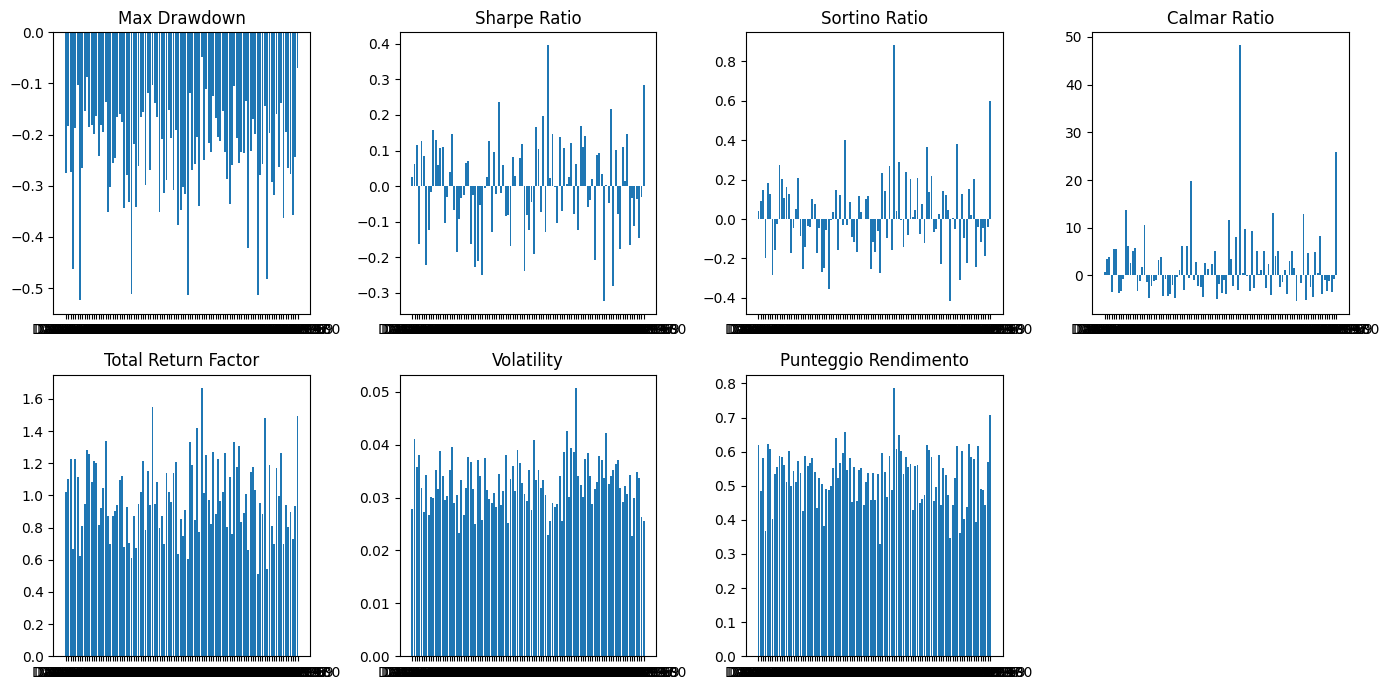

In [55]:
# Plot dei risultati
plt.figure(figsize=(14, 7))

# Plot del Max Drawdown per ogni dataset
plt.subplot(2, 4, 1)
plt.bar(results_df['Dataset'], results_df['Max Drawdown'])
plt.title('Max Drawdown')

# Plot dello Sharpe Ratio per ogni dataset
plt.subplot(2, 4, 2)
plt.bar(results_df['Dataset'], results_df['Sharpe Ratio'])
plt.title('Sharpe Ratio')

# Plot del Sortino Ratio per ogni dataset
plt.subplot(2, 4, 3)
plt.bar(results_df['Dataset'], results_df['Sortino Ratio'])
plt.title('Sortino Ratio')

# Plot del Calmar Ratio per ogni dataset
plt.subplot(2, 4, 4)
plt.bar(results_df['Dataset'], results_df['Calmar Ratio'])
plt.title('Calmar Ratio')

# Plot del Total Return Factor per ogni dataset
plt.subplot(2, 4, 5)
plt.bar(results_df['Dataset'], results_df['Total Return Factor'])
plt.title('Total Return Factor')

# Plot della Volatility per ogni dataset
plt.subplot(2, 4, 6)
plt.bar(results_df['Dataset'], results_df['Volatility'])
plt.title('Volatility')

# Plot del Punteggio Rendimento per ogni dataset
plt.subplot(2, 4, 7)
plt.bar(results_df['Dataset'], results_df['Punteggio Rendimento'])
plt.title('Punteggio Rendimento')

plt.tight_layout()
plt.show()

## Grid search

In [56]:
# # Esegui la grid search
# for ind, params in enumerate(param_combinations):
#     perc_primo_acquisto, vendita_immediata, perc_sbilanciamento_acquisto, soglia_minima_acquisto, soglia_minima_vendita, perc_stop_loss, compra_pure = params
#     print(f'Sto calcolando la combinazione {ind+1}/{total_combinations} ({params})...')
    
#     for i, df in enumerate(dati_da_usare):
#         transactions = trading_strategy(df, liquidita_mobile_iniziale, liquidita_fissa_iniziale, bitcoin_iniziali, perc_primo_acquisto, vendita_immediata, perc_sbilanciamento_acquisto, perc_commissione_acquisto, perc_commissione_vendita, min_acquisto, min_vendita, soglia_minima_acquisto, soglia_minima_vendita, perc_stop_loss, compra_pure)
#         portfolio_values = transactions['Valore Totale del Portafoglio']
        
#         # Calcola il Return Factor
#         total_return_factor = portfolio_values.iloc[-1] / portfolio_values[0]
        
#         # Calcola il punteggio rendimento
#         punteggio_rendimento = total_return_factor / ideal_returns[i]
        
#         # Aggiorna la coppia migliore e peggiore
#         if punteggio_rendimento > best_pair['score']:
#             best_pair = {'score': punteggio_rendimento, 'dataset': i, 'params': params, 'transactions': transactions}
#         if punteggio_rendimento < worst_pair['score']:
#             worst_pair = {'score': punteggio_rendimento, 'dataset': i, 'params': params, 'transactions': transactions}
        
#         # Salva i risultati
#         grid_search_results.append({
#             'dataset': i,
#             'perc_primo_acquisto': perc_primo_acquisto,
#             'vendita_immediata': vendita_immediata,
#             'perc_sbilanciamento_acquisto': perc_sbilanciamento_acquisto,
#             'soglia_minima_acquisto': soglia_minima_acquisto,
#             'soglia_minima_vendita': soglia_minima_vendita,
#             'perc_stop_loss': perc_stop_loss,
#             'compra_pure': compra_pure,
#             'Fattore Rendimento': total_return_factor,
#             'Punteggio Rendimento': punteggio_rendimento
#         })

#     print(f'Completata combinazione {ind+1}/{total_combinations}')

# # Converte i risultati in DataFrame per una migliore visualizzazione
# grid_search_results_df = pd.DataFrame(grid_search_results)

# # Funzione per creare il grafico delle transazioni
# def plot_transactions(df, transactions, title):
#     plt.figure(figsize=(20, 7))
#     plt.grid(True)
#     plt.plot(df['Timestamp'], df['Price'], label='Prezzi')
    
#     acquisti = transactions[transactions['Azione Attuale'].isin(['Acquisto', 'Primo Acquisto'])]
#     vendite = transactions[transactions['Azione Attuale'] == 'Vendita']
    
#     plt.scatter(acquisti['Data'], acquisti['Prezzo'], 
#                 s=acquisti['Quantità in € Comprata/Venduta']/acquisti['Quantità in € Comprata/Venduta'].max()*200, 
#                 color='green', alpha=0.6, label='Acquisti')
#     plt.scatter(vendite['Data'], vendite['Prezzo'], 
#                 s=vendite['Quantità in € Comprata/Venduta']/vendite['Quantità in € Comprata/Venduta'].max()*200, 
#                 color='red', alpha=0.6, label='Vendite')
    
#     plt.title(title)
#     plt.xlabel('Data')
#     plt.ylabel('Prezzo')
#     plt.legend()
#     plt.show()

# # Stampa e visualizza i risultati per la coppia migliore
# print("\nMiglior coppia:")
# print(f"Dataset: {best_pair['dataset']}")
# print(f"Parametri: {best_pair['params']}")
# print(f"Punteggio: {best_pair['score']}")
# plot_transactions(dati_da_usare[best_pair['dataset']], best_pair['transactions'], 'Transazioni per la Miglior Coppia')
# print("\nElenco transazioni per la miglior coppia:")
# print(best_pair['transactions'])

# # Stampa e visualizza i risultati per la coppia peggiore
# print("\nPeggior coppia:")
# print(f"Dataset: {worst_pair['dataset']}")
# print(f"Parametri: {worst_pair['params']}")
# print(f"Punteggio: {worst_pair['score']}")
# plot_transactions(dati_da_usare[worst_pair['dataset']], worst_pair['transactions'], 'Transazioni per la Peggior Coppia')
# print("\nElenco transazioni per la peggior coppia:")
# print(worst_pair['transactions'])

In [72]:
# Parametri da variare nella grid search
perc_primo_acquisto_values = [0.001, 0.01, 0.02]
vendita_immediata_values = [True]
perc_sbilanciamento_acquisto_values = [0.4, 0.6, 0.65]
soglia_minima_acquisto_values = [0.08, 0.1, 0.12]
soglia_minima_vendita_values = [0.2, 0.25, 0.27]
perc_stop_loss_values = [0, 0.001]
compra_pure_values = [True]
vendita_immediata_dinamica_values = [True] # Valutare se usare il numero medio di salite consecutive anzichè l'rsi
tempo_rsi_values = [2, 3, 4]
soglia_rsi_values = [13, 15, 17]


liquidita_mobile_iniziale = 1000
liquidita_fissa_iniziale = 0
bitcoin_iniziali = 0
perc_commissione_acquisto = 0.001
perc_commissione_vendita = 0.001
min_acquisto = 5
min_vendita = 5

# Funzioni per il calcolo delle metriche
def max_drawdown(portfolio_values):
    peak = portfolio_values.cummax()
    drawdown = (portfolio_values - peak) / peak
    max_dd = drawdown.min()
    return max_dd

def sharpe_ratio(portfolio_returns, risk_free_rate=0.0):
    excess_returns = portfolio_returns - risk_free_rate
    return excess_returns.mean() / excess_returns.std()

def sortino_ratio(portfolio_returns, risk_free_rate=0.0):
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std = downside_returns.std()
    return (portfolio_returns.mean() - risk_free_rate) / downside_std

def calmar_ratio(portfolio_returns, max_drawdown_value):
    annual_return = portfolio_returns.mean() * 252  # 252 è il numero medio di giorni di trading in un anno
    return annual_return / abs(max_drawdown_value)

# Calcola il rendimento ideale per ogni dataset e salva in una lista
ideal_returns = [calcola_rendimento_portafoglio_ideale(liquidita_mobile_iniziale + liquidita_fissa_iniziale, bitcoin_iniziali, df['Price'], min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita)[0] for df in dati_da_usare]

# Inizializza variabili per tenere traccia delle coppie migliori e peggiori
best_pair = {'score': -np.inf, 'total_return_factor': -np.inf, 'dataset': None, 'params': None, 'transactions': None}
worst_pair = {'score': np.inf, 'total_return_factor': np.inf, 'dataset': None, 'params': None, 'transactions': None}

# Lista per conservare i risultati della grid search
grid_search_results = []

# Genera tutte le combinazioni possibili dei parametri
param_combinations = list(itertools.product(perc_primo_acquisto_values, vendita_immediata_values, 
                                       perc_sbilanciamento_acquisto_values, soglia_minima_acquisto_values, soglia_minima_vendita_values, 
                                       perc_stop_loss_values, compra_pure_values, vendita_immediata_dinamica_values, tempo_rsi_values, soglia_rsi_values))

# Numero totale di combinazioni
total_combinations = len(param_combinations)

max_value = 0
max_rendimento_medio = 0

ind_partenza = 1 # Punteggio rendimento medio migliore trovato finora: 0.5497181196780808 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=15'] e fattore rendimento medio 1.0022933002359442 (combinazione numero 326)

ind_fine = total_combinations


saltate = 0
calcolate = 0

# Esegui la grid search
for ind, params in enumerate(param_combinations):
    if ind + 1 >= ind_partenza and ind + 1 <= ind_fine:
        perc_primo_acquisto, vendita_immediata, perc_sbilanciamento_acquisto, soglia_minima_acquisto, soglia_minima_vendita, perc_stop_loss, compra_pure, vendita_immediata_dinamica, tempo_rsi, soglia_rsi = params

        nomi_parametri = ['perc_primo_acquisto', 'vendita_immediata', 'perc_sbilanciamento_acquisto', 'soglia_minima_acquisto', 'soglia_minima_vendita', 'perc_stop_loss', 'compra_pure', 'vendita_immediata_dinamica', 'tempo_rsi', 'soglia_rsi']
        parametri_e_valori = [nomi_parametri[j] + "=" + str(params[j]) for j in range(len(params))]

        if not vendita_immediata_dinamica and (tempo_rsi != tempo_rsi_values[0] or soglia_rsi != soglia_rsi_values[0]) or vendita_immediata_dinamica and vendita_immediata != vendita_immediata_values[0] or perc_primo_acquisto == 1 and (perc_sbilanciamento_acquisto != perc_sbilanciamento_acquisto_values[0] or soglia_minima_acquisto != soglia_minima_acquisto_values[0] or compra_pure != compra_pure_values[0]) or vendita_immediata and perc_stop_loss != perc_stop_loss_values[0]:
            print(f'Salto la combinazione {ind+1}/{total_combinations} ({parametri_e_valori}) perchè sarebbe identica a una combinazione già vista...\n')
            saltate += 1
            continue

        print(f'Sto calcolando la combinazione {ind+1}/{total_combinations} ({parametri_e_valori}) ({calcolate} calcolate, {saltate} saltate)...')
        calcolate += 1
        
        # Liste per conservare i rendimenti per ogni dataset
        total_return_factors = []
        
        for i, df in enumerate(dati_da_usare):
            transactions = trading_strategy_modified(df, liquidita_mobile_iniziale, liquidita_fissa_iniziale, bitcoin_iniziali, perc_primo_acquisto, vendita_immediata, perc_sbilanciamento_acquisto, perc_commissione_acquisto, perc_commissione_vendita, min_acquisto, min_vendita, soglia_minima_acquisto, soglia_minima_vendita, perc_stop_loss, compra_pure, vendita_immediata_dinamica, tempo_rsi, soglia_rsi)
            
            portfolio_values = transactions['Valore Totale del Portafoglio']
            
            # Calcola i rendimenti giornalieri del portafoglio
            # portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]

            # Calcolo il Return Factor
            total_return_factor = portfolio_values.iloc[-1] / portfolio_values[0]
            total_return_factors.append(total_return_factor)

            # Calcola il punteggio rendimento
            punteggio_rendimento = total_return_factor / ideal_returns[i]
            
            # Aggiorna la coppia migliore e peggiore
            if punteggio_rendimento > best_pair['score']:
                best_pair = {'score': punteggio_rendimento, 'total_return_factor': total_return_factor, 'dataset': i, 'params': parametri_e_valori, 'transactions': transactions}
            if punteggio_rendimento < worst_pair['score']:
                worst_pair = {'score': punteggio_rendimento, 'total_return_factor': total_return_factor, 'dataset': i, 'params': parametri_e_valori, 'transactions': transactions}

        rendimento_medio = np.mean(total_return_factors)
        
        # Calcola il punteggio rendimento medio per la combinazione di parametri
        punteggio_rendimento_medio = np.mean([trf / ir for trf, ir in zip(total_return_factors, ideal_returns)])
        
        # Salva i risultati
        grid_search_results.append({
            'perc_primo_acquisto': perc_primo_acquisto,
            'vendita_immediata': vendita_immediata,
            'perc_sbilanciamento_acquisto': perc_sbilanciamento_acquisto,
            'soglia_minima_acquisto': soglia_minima_acquisto,
            'soglia_minima_vendita': soglia_minima_vendita,
            'perc_stop_loss': perc_stop_loss,
            'compra_pure': compra_pure,
            'vendita_immediata_dinamica': vendita_immediata_dinamica,
            'tempo_rsi': tempo_rsi,
            'soglia_rsi': soglia_rsi,
            'Fattore Rendimento medio': rendimento_medio,
            'Punteggio Rendimento Medio': punteggio_rendimento_medio
        })

        print(f'Fattore Rendimento medio: {rendimento_medio}')
        print(f'Punteggio rendimento medio: {punteggio_rendimento_medio}')

        if punteggio_rendimento_medio > max_value:
            max_value = punteggio_rendimento_medio
            max_rendimento_medio = rendimento_medio
            combinazione_max = parametri_e_valori
            ind_max = ind

        print(f'Punteggio rendimento medio migliore trovato finora: {max_value} con i parametri {combinazione_max} e fattore rendimento medio {max_rendimento_medio} (combinazione numero {ind_max+1})\n')

# Converte i risultati in DataFrame per una migliore visualizzazione
grid_search_results_df = pd.DataFrame(grid_search_results)

# Ordina i risultati per Punteggio Rendimento Medio in ordine decrescente
sorted_results_df = grid_search_results_df.sort_values(by='Punteggio Rendimento Medio', ascending=False)

Sto calcolando la combinazione 1/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13']) (0 calcolate, 0 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 2/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (1 calcolate, 0 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 3/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (2 calcolate, 0 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 4/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (3 calcolate, 0 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 20/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (10 calcolate, 9 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 21/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (11 calcolate, 9 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 22/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (12 calcolate, 9 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 co

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 38/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (19 calcolate, 18 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 39/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (20 calcolate, 18 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 40/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (21 calcolate, 18 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 c

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 56/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (28 calcolate, 27 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 57/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (29 calcolate, 27 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 58/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (30 calcolate, 27 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 74/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (37 calcolate, 36 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 75/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (38 calcolate, 36 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 76/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (39 calcolate, 36 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 co

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 92/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (46 calcolate, 45 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 93/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (47 calcolate, 45 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 94/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (48 calcolate, 45 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 co

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 110/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (55 calcolate, 54 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 111/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (56 calcolate, 54 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 112/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (57 calcolate, 54 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 c

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 128/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (64 calcolate, 63 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 129/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (65 calcolate, 63 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 130/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (66 calcolate, 63 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 146/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (73 calcolate, 72 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 147/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (74 calcolate, 72 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 148/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (75 calcolate, 72 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 164/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (82 calcolate, 81 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 165/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (83 calcolate, 81 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 166/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (84 calcolate, 81 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 c

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 182/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (91 calcolate, 90 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 183/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (92 calcolate, 90 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 184/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (93 calcolate, 90 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 200/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (100 calcolate, 99 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 201/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (101 calcolate, 99 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 202/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (102 calcolate, 99 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 218/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (109 calcolate, 108 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 219/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (110 calcolate, 108 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 220/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (111 calcolate, 108 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 236/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (118 calcolate, 117 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 237/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (119 calcolate, 117 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 238/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (120 calcolate, 117 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 254/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (127 calcolate, 126 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 255/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (128 calcolate, 126 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 256/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (129 calcolate, 126 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 272/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (136 calcolate, 135 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 273/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (137 calcolate, 135 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 274/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (138 calcolate, 135 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 290/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (145 calcolate, 144 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 291/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (146 calcolate, 144 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 292/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (147 calcolate, 144 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.54898337899541

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 308/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (154 calcolate, 153 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 309/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (155 calcolate, 153 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 310/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (156 calcolate, 153 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.54898337899541

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 326/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (163 calcolate, 162 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 327/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (164 calcolate, 162 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 328/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (165 calcolate, 162 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.54898337899541

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 344/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (172 calcolate, 171 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 345/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (173 calcolate, 171 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 346/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (174 calcolate, 171 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.5489833789954

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 362/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (181 calcolate, 180 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 363/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (182 calcolate, 180 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 364/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (183 calcolate, 180 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.5489833789954

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 380/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (190 calcolate, 189 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 381/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (191 calcolate, 189 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 382/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (192 calcolate, 189 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 398/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (199 calcolate, 198 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 399/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (200 calcolate, 198 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 400/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (201 calcolate, 198 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.54898337899541

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 416/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (208 calcolate, 207 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 417/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (209 calcolate, 207 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 418/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (210 calcolate, 207 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.54898337899541

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 434/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (217 calcolate, 216 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 435/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (218 calcolate, 216 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 436/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (219 calcolate, 216 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.54898337899541

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 452/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (226 calcolate, 225 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 453/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (227 calcolate, 225 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 454/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (228 calcolate, 225 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.5489833789954

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 470/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (235 calcolate, 234 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 471/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (236 calcolate, 234 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.548983378995418 con i parametri ['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 0.9999955349302155 (combinazione numero 1)

Sto calcolando la combinazione 472/1458 (['perc_primo_acquisto=0.001', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (237 calcolate, 234 saltate)...
Fattore Rendimento medio: 0.9999955349302155
Punteggio rendimento medio: 0.548983378995418
Punteggio rendimento medio migliore trovato finora: 0.5489833789954

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0017393977591367
Punteggio rendimento medio: 0.5492250917419308
Punteggio rendimento medio migliore trovato finora: 0.5492250917419308 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 1.0017393977591367 (combinazione numero 487)

Sto calcolando la combinazione 488/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (244 calcolate, 243 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0017393977591367
Punteggio rendimento medio: 0.5492250917419308
Punteggio rendimento medio migliore trovato finora: 0.5492250917419308 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 1.0017393977591367 (combinazione numero 487)

Sto calcolando la combinazione 489/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (245 calcolate, 243 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0017393977591367
Punteggio rendimento medio: 0.5492250917419308
Punteggio rendimento medio migliore trovato finora: 0.5492250917419308 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 1.0017393977591367 (combinazione numero 487)

Sto calcolando la combinazione 490/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (246 calcolate, 243 saltate)...
Fattore Rendimento medio: 1.0017733144551162
Punteggio rendimento medio: 0.5492410457808101
Punteggio rendimento medio migliore trovato finora: 0.549241045780

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.002767856126678
Punteggio rendimento medio: 0.5499439990796308
Punteggio rendimento medio migliore trovato finora: 0.5499439990796308 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 1.002767856126678 (combinazione numero 505)

Sto calcolando la combinazione 506/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (253 calcolate, 252 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.002767856126678
Punteggio rendimento medio: 0.5499439990796308
Punteggio rendimento medio migliore trovato finora: 0.5499439990796308 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 1.002767856126678 (combinazione numero 505)

Sto calcolando la combinazione 507/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (254 calcolate, 252 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.002767856126678
Punteggio rendimento medio: 0.5499439990796308
Punteggio rendimento medio migliore trovato finora: 0.5499439990796308 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 1.002767856126678 (combinazione numero 505)

Sto calcolando la combinazione 508/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (255 calcolate, 252 saltate)...
Fattore Rendimento medio: 1.0028137609731038
Punteggio rendimento medio: 0.5499630814173393
Punteggio rendimento medio migliore trovato finora: 0.549963081417

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.002765033115184
Punteggio rendimento medio: 0.5499421261308887
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 524/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (262 calcolate, 261 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.002765033115184
Punteggio rendimento medio: 0.5499421261308887
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 525/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (263 calcolate, 261 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.002765033115184
Punteggio rendimento medio: 0.5499421261308887
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 526/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (264 calcolate, 261 saltate)...
Fattore Rendimento medio: 1.0027961566883679
Punteggio rendimento medio: 0.5499542925928632
Punteggio rendimento medio migliore trovato finora: 0.549963638716

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0010233317841586
Punteggio rendimento medio: 0.5492547143563773
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 542/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (271 calcolate, 270 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0010233317841586
Punteggio rendimento medio: 0.5492547143563773
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 543/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (272 calcolate, 270 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0010233317841586
Punteggio rendimento medio: 0.5492547143563773
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 544/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (273 calcolate, 270 saltate)...
Fattore Rendimento medio: 1.000994199934435
Punteggio rendimento medio: 0.5492421989861034
Punteggio rendimento medio migliore trovato finora: 0.54996363871679

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0007846146536683
Punteggio rendimento medio: 0.5491606537571422
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 560/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (280 calcolate, 279 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0007846146536683
Punteggio rendimento medio: 0.5491606537571422
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 561/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (281 calcolate, 279 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0007846146536683
Punteggio rendimento medio: 0.5491606537571422
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 562/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (282 calcolate, 279 saltate)...
Fattore Rendimento medio: 1.000785577820227
Punteggio rendimento medio: 0.549161199901163
Punteggio rendimento medio migliore trovato finora: 0.54996363871679

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0007921601859846
Punteggio rendimento medio: 0.5491640906396693
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 578/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (289 calcolate, 288 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0007921601859846
Punteggio rendimento medio: 0.5491640906396693
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 579/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (290 calcolate, 288 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0007921601859846
Punteggio rendimento medio: 0.5491640906396693
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 580/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (291 calcolate, 288 saltate)...
Fattore Rendimento medio: 1.0007736013060282
Punteggio rendimento medio: 0.5491554857798918
Punteggio rendimento medio migliore trovato finora: 0.549963638716

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0008365015180702
Punteggio rendimento medio: 0.5491717302697958
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 596/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (298 calcolate, 297 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0008365015180702
Punteggio rendimento medio: 0.5491717302697958
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 597/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (299 calcolate, 297 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0008365015180702
Punteggio rendimento medio: 0.5491717302697958
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 598/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (300 calcolate, 297 saltate)...
Fattore Rendimento medio: 1.0007976283914524
Punteggio rendimento medio: 0.5491538829767054
Punteggio rendimento medio migliore trovato finora: 0.549963638716

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0012397205460313
Punteggio rendimento medio: 0.5494249620457545
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 614/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (307 calcolate, 306 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0012397205460313
Punteggio rendimento medio: 0.5494249620457545
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 615/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (308 calcolate, 306 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0012397205460313
Punteggio rendimento medio: 0.5494249620457545
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 616/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (309 calcolate, 306 saltate)...
Fattore Rendimento medio: 1.0012468483708856
Punteggio rendimento medio: 0.5494285573609681
Punteggio rendimento medio migliore trovato finora: 0.54996363871

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0014043193645217
Punteggio rendimento medio: 0.5495153874097481
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 632/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (316 calcolate, 315 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0014043193645217
Punteggio rendimento medio: 0.5495153874097481
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 633/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (317 calcolate, 315 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0014043193645217
Punteggio rendimento medio: 0.5495153874097481
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 634/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (318 calcolate, 315 saltate)...
Fattore Rendimento medio: 1.0013966887410033
Punteggio rendimento medio: 0.5495118595791104
Punteggio rendimento medio migliore trovato finora: 0.54996363871

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.000549287119886
Punteggio rendimento medio: 0.5478610900768135
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 650/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (325 calcolate, 324 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.000549287119886
Punteggio rendimento medio: 0.5478610900768135
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 651/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (326 calcolate, 324 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.000549287119886
Punteggio rendimento medio: 0.5478610900768135
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 652/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (327 calcolate, 324 saltate)...
Fattore Rendimento medio: 1.0008961975267658
Punteggio rendimento medio: 0.5480430221042174
Punteggio rendimento medio migliore trovato finora: 0.5499636387167

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9995094552023234
Punteggio rendimento medio: 0.5475267470834307
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 668/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (334 calcolate, 333 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9995094552023234
Punteggio rendimento medio: 0.5475267470834307
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 669/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (335 calcolate, 333 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9995094552023234
Punteggio rendimento medio: 0.5475267470834307
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 670/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (336 calcolate, 333 saltate)...
Fattore Rendimento medio: 0.9996502396393602
Punteggio rendimento medio: 0.5475850780307894
Punteggio rendimento medio migliore trovato finora: 0.54996363871

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9995721039769323
Punteggio rendimento medio: 0.5475527810464331
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 686/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (343 calcolate, 342 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9995721039769323
Punteggio rendimento medio: 0.5475527810464331
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 687/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (344 calcolate, 342 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9995721039769323
Punteggio rendimento medio: 0.5475527810464331
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 688/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (345 calcolate, 342 saltate)...
Fattore Rendimento medio: 0.9996668242088214
Punteggio rendimento medio: 0.547591215846209
Punteggio rendimento medio migliore trovato finora: 0.549963638716

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0009531533162908
Punteggio rendimento medio: 0.54885734594381
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 704/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (352 calcolate, 351 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0009531533162908
Punteggio rendimento medio: 0.54885734594381
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 705/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (353 calcolate, 351 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0009531533162908
Punteggio rendimento medio: 0.54885734594381
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 706/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (354 calcolate, 351 saltate)...
Fattore Rendimento medio: 1.0009486518166861
Punteggio rendimento medio: 0.548857030619952
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0022853322028407
Punteggio rendimento medio: 0.5497148520316955
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 722/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (361 calcolate, 360 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0022853322028407
Punteggio rendimento medio: 0.5497148520316955
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 723/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (362 calcolate, 360 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0022853322028407
Punteggio rendimento medio: 0.5497148520316955
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 724/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (363 calcolate, 360 saltate)...
Fattore Rendimento medio: 1.0022873793831297
Punteggio rendimento medio: 0.5497156088893727
Punteggio rendimento medio migliore trovato finora: 0.549963638716

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.000590882715174
Punteggio rendimento medio: 0.5487761256690225
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 740/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (370 calcolate, 369 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.000590882715174
Punteggio rendimento medio: 0.5487761256690225
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 741/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (371 calcolate, 369 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.000590882715174
Punteggio rendimento medio: 0.5487761256690225
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 742/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (372 calcolate, 369 saltate)...
Fattore Rendimento medio: 1.000561257859446
Punteggio rendimento medio: 0.5487623274655682
Punteggio rendimento medio migliore trovato finora: 0.54996363871679

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0019169326429025
Punteggio rendimento medio: 0.5495474101074321
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 758/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (379 calcolate, 378 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0019169326429025
Punteggio rendimento medio: 0.5495474101074321
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 759/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (380 calcolate, 378 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0019169326429025
Punteggio rendimento medio: 0.5495474101074321
Punteggio rendimento medio migliore trovato finora: 0.5499636387167928 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.4', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.002815049273878 (combinazione numero 512)

Sto calcolando la combinazione 760/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (381 calcolate, 378 saltate)...
Fattore Rendimento medio: 1.001914174553458
Punteggio rendimento medio: 0.5495466945335482
Punteggio rendimento medio migliore trovato finora: 0.5499636387167

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0029001564641278
Punteggio rendimento medio: 0.5501830729957224
Punteggio rendimento medio migliore trovato finora: 0.5501830729957224 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 1.0029001564641278 (combinazione numero 775)

Sto calcolando la combinazione 776/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (388 calcolate, 387 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0029001564641278
Punteggio rendimento medio: 0.5501830729957224
Punteggio rendimento medio migliore trovato finora: 0.5501830729957224 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 1.0029001564641278 (combinazione numero 775)

Sto calcolando la combinazione 777/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (389 calcolate, 387 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0029001564641278
Punteggio rendimento medio: 0.5501830729957224
Punteggio rendimento medio migliore trovato finora: 0.5501830729957224 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 1.0029001564641278 (combinazione numero 775)

Sto calcolando la combinazione 778/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (390 calcolate, 387 saltate)...
Fattore Rendimento medio: 1.0029043409139735
Punteggio rendimento medio: 0.5501849117369918
Punteggio rendimento medio migliore trovato finora: 0.5501849117

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.002926500713338
Punteggio rendimento medio: 0.5501948124894814
Punteggio rendimento medio migliore trovato finora: 0.5501948124894814 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 1.002926500713338 (combinazione numero 793)

Sto calcolando la combinazione 794/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (397 calcolate, 396 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.002926500713338
Punteggio rendimento medio: 0.5501948124894814
Punteggio rendimento medio migliore trovato finora: 0.5501948124894814 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 1.002926500713338 (combinazione numero 793)

Sto calcolando la combinazione 795/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (398 calcolate, 396 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.002926500713338
Punteggio rendimento medio: 0.5501948124894814
Punteggio rendimento medio migliore trovato finora: 0.5501948124894814 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=13'] e fattore rendimento medio 1.002926500713338 (combinazione numero 793)

Sto calcolando la combinazione 796/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (399 calcolate, 396 saltate)...
Fattore Rendimento medio: 1.002920292948263
Punteggio rendimento medio: 0.5501918445964474
Punteggio rendimento medio migliore trovato finora: 0.5501948124894

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0016930177605765
Punteggio rendimento medio: 0.548215981150116
Punteggio rendimento medio migliore trovato finora: 0.550204086903936 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.0029471492754225 (combinazione numero 800)

Sto calcolando la combinazione 812/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (406 calcolate, 405 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0016930177605765
Punteggio rendimento medio: 0.548215981150116
Punteggio rendimento medio migliore trovato finora: 0.550204086903936 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.0029471492754225 (combinazione numero 800)

Sto calcolando la combinazione 813/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (407 calcolate, 405 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.0016930177605765
Punteggio rendimento medio: 0.548215981150116
Punteggio rendimento medio migliore trovato finora: 0.550204086903936 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.0029471492754225 (combinazione numero 800)

Sto calcolando la combinazione 814/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (408 calcolate, 405 saltate)...
Fattore Rendimento medio: 1.001774640713473
Punteggio rendimento medio: 0.5482506703576903
Punteggio rendimento medio migliore trovato finora: 0.5502040869039

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9997849731299538
Punteggio rendimento medio: 0.547430202438833
Punteggio rendimento medio migliore trovato finora: 0.550204086903936 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.0029471492754225 (combinazione numero 800)

Sto calcolando la combinazione 830/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (415 calcolate, 414 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9997849731299538
Punteggio rendimento medio: 0.547430202438833
Punteggio rendimento medio migliore trovato finora: 0.550204086903936 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.0029471492754225 (combinazione numero 800)

Sto calcolando la combinazione 831/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (416 calcolate, 414 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9997849731299538
Punteggio rendimento medio: 0.547430202438833
Punteggio rendimento medio migliore trovato finora: 0.550204086903936 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.0029471492754225 (combinazione numero 800)

Sto calcolando la combinazione 832/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (417 calcolate, 414 saltate)...
Fattore Rendimento medio: 0.9999291637929218
Punteggio rendimento medio: 0.547488799295106
Punteggio rendimento medio migliore trovato finora: 0.550204086903

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9998219184018137
Punteggio rendimento medio: 0.547444520595964
Punteggio rendimento medio migliore trovato finora: 0.550204086903936 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.0029471492754225 (combinazione numero 800)

Sto calcolando la combinazione 848/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (424 calcolate, 423 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9998219184018137
Punteggio rendimento medio: 0.547444520595964
Punteggio rendimento medio migliore trovato finora: 0.550204086903936 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.0029471492754225 (combinazione numero 800)

Sto calcolando la combinazione 849/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (425 calcolate, 423 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9998219184018137
Punteggio rendimento medio: 0.547444520595964
Punteggio rendimento medio migliore trovato finora: 0.550204086903936 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.0029471492754225 (combinazione numero 800)

Sto calcolando la combinazione 850/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.08', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (426 calcolate, 423 saltate)...
Fattore Rendimento medio: 0.9999532663194168
Punteggio rendimento medio: 0.5474981707564543
Punteggio rendimento medio migliore trovato finora: 0.55020408690

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.00034704889603
Punteggio rendimento medio: 0.5483635237425818
Punteggio rendimento medio migliore trovato finora: 0.550204086903936 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.0029471492754225 (combinazione numero 800)

Sto calcolando la combinazione 866/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (433 calcolate, 432 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.00034704889603
Punteggio rendimento medio: 0.5483635237425818
Punteggio rendimento medio migliore trovato finora: 0.550204086903936 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.0029471492754225 (combinazione numero 800)

Sto calcolando la combinazione 867/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (434 calcolate, 432 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 1.00034704889603
Punteggio rendimento medio: 0.5483635237425818
Punteggio rendimento medio migliore trovato finora: 0.550204086903936 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.0029471492754225 (combinazione numero 800)

Sto calcolando la combinazione 868/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.2', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (435 calcolate, 432 saltate)...
Fattore Rendimento medio: 1.0006127425648963
Punteggio rendimento medio: 0.5485123360694932
Punteggio rendimento medio migliore trovato finora: 0.55020408690393

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9997941353366242
Punteggio rendimento medio: 0.5481924736744619
Punteggio rendimento medio migliore trovato finora: 0.550204086903936 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.0029471492754225 (combinazione numero 800)

Sto calcolando la combinazione 884/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=15']) (442 calcolate, 441 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9997941353366242
Punteggio rendimento medio: 0.5481924736744619
Punteggio rendimento medio migliore trovato finora: 0.550204086903936 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.0029471492754225 (combinazione numero 800)

Sto calcolando la combinazione 885/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=2', 'soglia_rsi=17']) (443 calcolate, 441 saltate)...


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_5108\3461473948.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * avg_gain / (avg_gain + avg_loss)


Fattore Rendimento medio: 0.9997941353366242
Punteggio rendimento medio: 0.5481924736744619
Punteggio rendimento medio migliore trovato finora: 0.550204086903936 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.6', 'soglia_minima_acquisto=0.12', 'soglia_minima_vendita=0.27', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=4', 'soglia_rsi=15'] e fattore rendimento medio 1.0029471492754225 (combinazione numero 800)

Sto calcolando la combinazione 886/1458 (['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.65', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']) (444 calcolate, 441 saltate)...
Fattore Rendimento medio: 0.9997529998083543
Punteggio rendimento medio: 0.5481742520094027
Punteggio rendimento medio migliore trovato finora: 0.55020408690

In [ ]:
sorted_results_df.head(15)

,perc_primo_acquisto,vendita_immediata,perc_sbilanciamento_acquisto,soglia_minima_acquisto,soglia_minima_vendita,perc_stop_loss,compra_pure,vendita_immediata_dinamica,tempo_rsi,soglia_rsi,Fattore Rendimento medio,Punteggio Rendimento Medio
127,0.1,False,0.8,0.1,0.30,0.000,False,False,3,10,1.007194,0.547960
135,0.1,False,0.8,0.1,0.35,0.008,False,False,3,10,1.007039,0.547938
137,0.1,False,0.8,0.1,0.35,0.009,False,False,3,10,1.007039,0.547938
129,0.1,False,0.8,0.1,0.30,0.008,False,False,3,10,1.006821,0.547847
131,0.1,False,0.8,0.1,0.30,0.009,False,False,3,10,1.006821,0.547847
31,0.1,False,0.6,0.2,0.25,0.000,False,False,3,10,1.001806,0.547822
125,0.1,False,0.8,0.1,0.25,0.009,False,False,3,10,1.006743,0.547716
123,0.1,False,0.8,0.1,0.25,0.008,False,False,3,10,1.006712,0.547699
73,0.1,False,0.7,0.1,0.30,0.000,False,False,3,10,1.004094,0.547687
81,0.1,False,0.7,0.1,0.35,0.008,False,False,3,10,1.004029,0.547678


In [ ]:
sorted_results_df[['Fattore Rendimento medio', 'Punteggio Rendimento Medio']].value_counts()

Fattore Rendimento medio  Punteggio Rendimento Medio
0.998440                  0.544051                      7
1.013628                  0.546810                      7
1.006109                  0.545826                      7
0.997582                  0.542983                      7
0.998283                  0.543398                      7
                                                       ..
1.003908                  0.547626                      1
1.003947                  0.544124                      1
1.004022                  0.545619                      1
1.004082                  0.545651                      1
1.004378                  0.544377                      1
Name: count, Length: 408, dtype: int64

In [ ]:
def plot_transactions(df, transactions, title):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    transactions['Data'] = pd.to_datetime(transactions['Data'])
    
    plt.figure(figsize=(20, 7))
    plt.grid()
    plt.plot(df['Timestamp'], df['Price'], label='Prezzi')
    
    acquisti = transactions[transactions['Azione Attuale'].isin(['Acquisto', 'Primo Acquisto'])]
    vendite = transactions[transactions['Azione Attuale'].isin(['Vendita', 'Vendita (Stop-Loss)'])]
    
    # Calcolo delle dimensioni dei punti
    max_acquisto = acquisti['Quantità in € Comprata/Venduta'].max()
    max_vendita = vendite['Quantità in € Comprata/Venduta'].max()
    
    def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
        return min_size + (max_size - min_size) * (quantita / max_quantita)
    
    # Rimuovi eventuali NaN o infiniti
    # acquisti = acquisti.dropna(subset=['Data', 'Prezzo', 'Quantità in € Comprata/Venduta'])
    # vendite = vendite.dropna(subset=['Data', 'Prezzo', 'Quantità in € Comprata/Venduta'])
    
    dimensioni_acquisti = acquisti['Quantità in € Comprata/Venduta'].apply(lambda x: calcola_dimensione(x, max_acquisto))
    dimensioni_vendite = vendite['Quantità in € Comprata/Venduta'].apply(lambda x: calcola_dimensione(x, max_vendita))
    
    # Verifica che tutte le dimensioni siano corrette
    assert len(acquisti['Data']) == len(acquisti['Prezzo']) == len(dimensioni_acquisti)
    assert len(vendite['Data']) == len(vendite['Prezzo']) == len(dimensioni_vendite)
    
    if not acquisti.empty:
        plt.scatter(acquisti['Data'], acquisti['Prezzo'], 
                    s=dimensioni_acquisti, 
                    color='green', alpha=0.6, label='Acquisti')
    
    if not vendite.empty:
        plt.scatter(vendite['Data'], vendite['Prezzo'], 
                    s=dimensioni_vendite, 
                    color='red', alpha=0.6, label='Vendite')
    
    plt.title(title)
    plt.xlabel('Data')
    plt.ylabel('Prezzo')
    plt.legend()
    plt.show()


Miglior coppia:
Dataset: 90
Parametri: ['perc_primo_acquisto=0.2', 'vendita_immediata=False', 'perc_sbilanciamento_acquisto=0.8', 'soglia_minima_acquisto=0.1', 'soglia_minima_vendita=0.3', 'perc_stop_loss=0.008', 'compra_pure=True', 'vendita_immediata_dinamica=False', 'tempo_rsi=3', 'soglia_rsi=10']
Fattore di rendimento totale: 1.4241854268322702
Punteggio: 0.7556324496649983


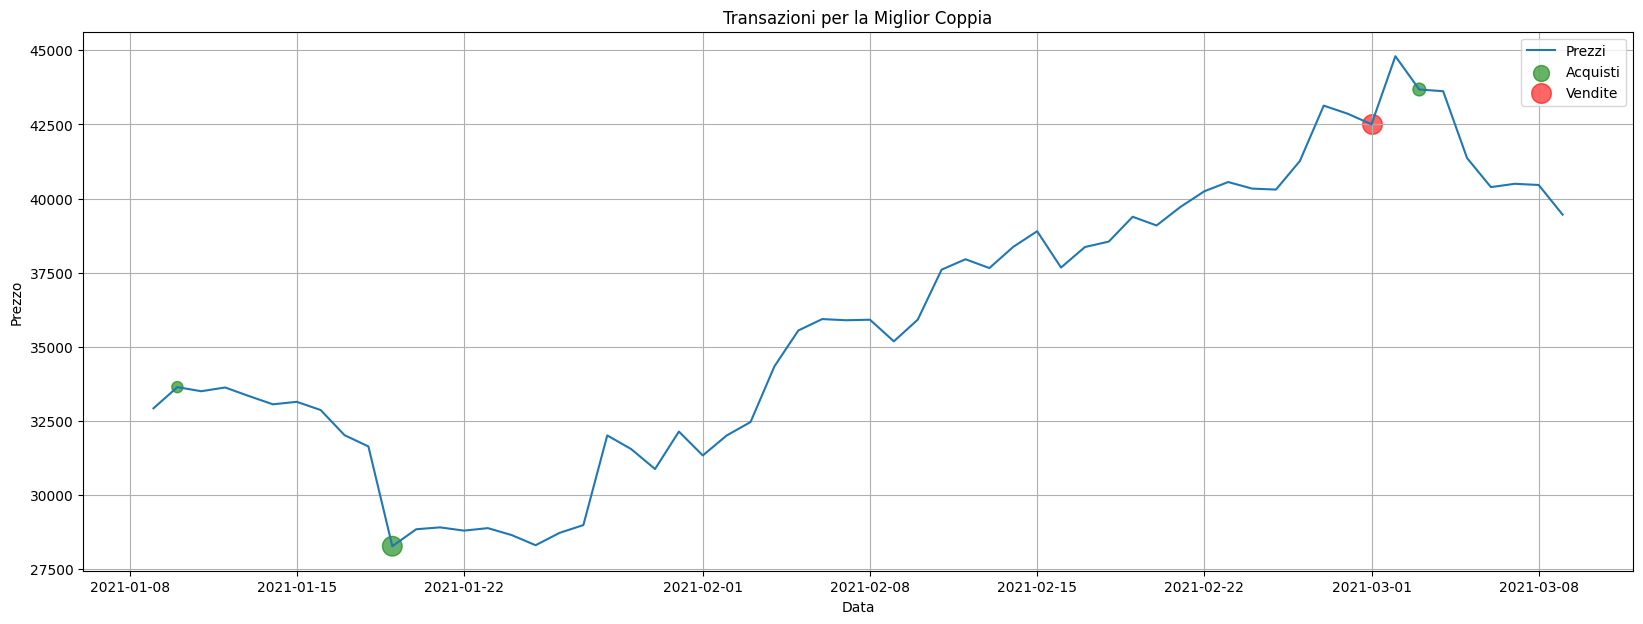


Elenco transazioni per la miglior coppia:


,Data,Numero giorno,Prezzo,Ultima Azione,Azione Attuale,% acquisto/vendita di LM,Quantità in € Comprata/Venduta,Quantità di Bitcoin Comprati/Venduti,Liquidità Mobile,Liquidità Fissa,Bitcoin Posseduti,Valore Totale del Portafoglio
0,2021-01-10,1,33642.866669,-,Primo Acquisto,0.2,200.000000,0.005939,800.000000,0,0.005939,999.800000
9,2021-01-19,10,28278.930869,Primo Acquisto,Acquisto,1.0,800.000000,0.028261,0.000000,0,0.034200,967.144380
50,2021-03-01,51,42504.552484,Acquisto,Vendita (Stop-Loss),1.0,1452.209463,0.034200,1452.209463,0,0.000000,1452.209463
52,2021-03-03,53,43676.430378,Vendita (Stop-Loss),Primo Acquisto,0.2,290.441893,0.006643,1161.767571,0,0.006643,1451.919022


In [ ]:
# Stampa e visualizza i risultati per la coppia migliore
print("\nMiglior coppia:")
print(f"Dataset: {best_pair['dataset']}")
print(f"Parametri: {best_pair['params']}")
print(f"Fattore di rendimento totale: {best_pair['total_return_factor']}")
print(f"Punteggio: {best_pair['score']}")
plot_transactions(dati_da_usare[best_pair['dataset']], best_pair['transactions'], 'Transazioni per la Miglior Coppia')
print("\nElenco transazioni per la miglior coppia:")
best_pair['transactions'][best_pair['transactions']['Azione Attuale'] != '-']


Peggior coppia:
Dataset: 52
Parametri: ['perc_primo_acquisto=0.2', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.8', 'soglia_minima_acquisto=0.05', 'soglia_minima_vendita=0.25', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=10']
Fattore di rendimento totale: 0.6421546974660424
Punteggio: 0.3494711761799836


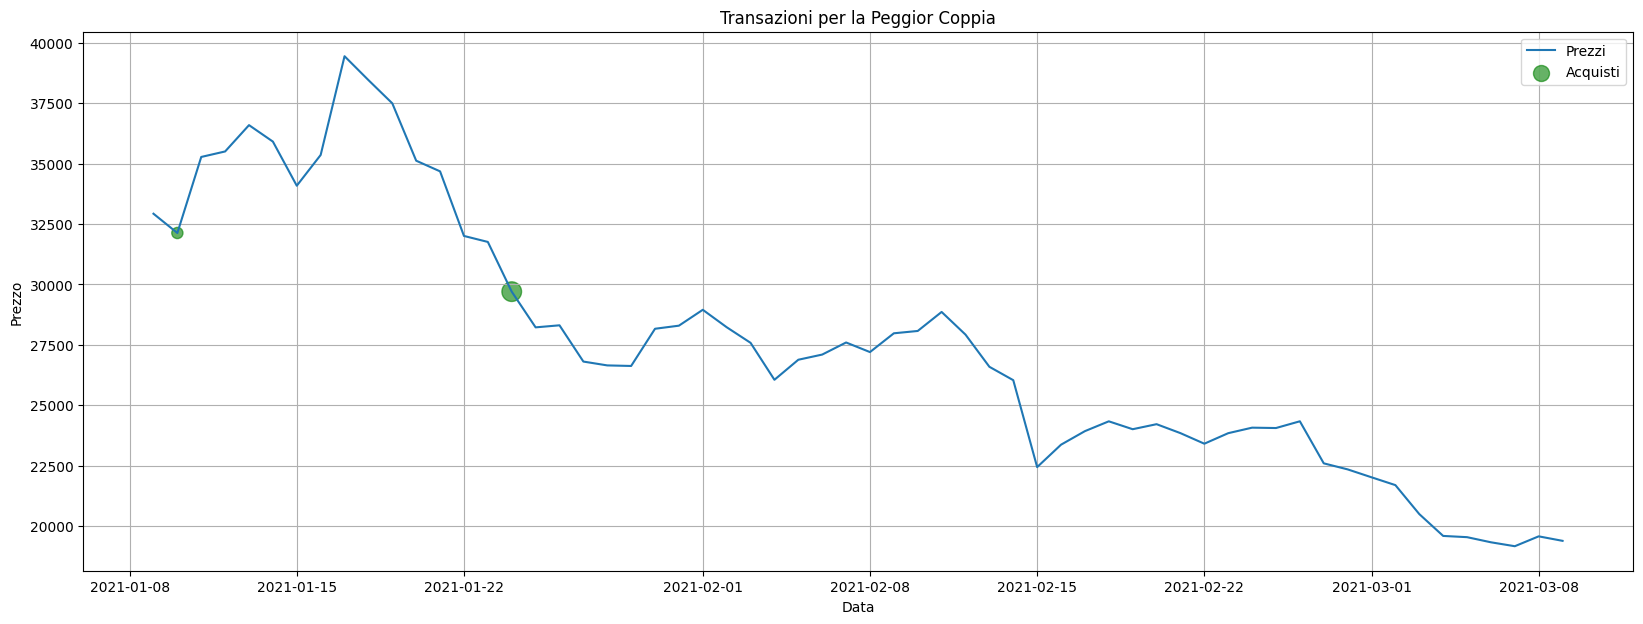


Elenco transazioni per la peggior coppia:


,Data,Numero giorno,Prezzo,Ultima Azione,Azione Attuale,% acquisto/vendita di LM,Quantità in € Comprata/Venduta,Quantità di Bitcoin Comprati/Venduti,Liquidità Mobile,Liquidità Fissa,Bitcoin Posseduti,Valore Totale del Portafoglio
0,2021-01-10,1,32129.415549,-,Primo Acquisto,0.2,200.0,0.006219,800.0,0,0.006219,999.80000
14,2021-01-24,15,29700.713195,Primo Acquisto,Acquisto,1.0,800.0,0.026908,0.0,0,0.033127,983.89687


In [ ]:
# Stampa e visualizza i risultati per la coppia peggiore
print("\nPeggior coppia:")
print(f"Dataset: {worst_pair['dataset']}")
print(f"Parametri: {worst_pair['params']}")
print(f"Fattore di rendimento totale: {worst_pair['total_return_factor']}")
print(f"Punteggio: {worst_pair['score']}")
plot_transactions(dati_da_usare[worst_pair['dataset']], worst_pair['transactions'], 'Transazioni per la Peggior Coppia')
print("\nElenco transazioni per la peggior coppia:")
worst_pair['transactions'][worst_pair['transactions']['Azione Attuale'] != '-']

In [ ]:
# Idee successive:
# - Capire perchè con alcuni dataset una certa combinazione funziona bene e un'altra funziona male
# - Per farlo, clusterizzare i dataset (numero di cluster da decidere) per ogni combinazione (ad esempio, per una fissata combinazione, un gruppo di dataset può aver performato benissimo, un altro così così e un altro malissimo)
# - Cercare di capire cos'hanno in comune i dataset di uno stesso cluster e cercare di definire poi una o più caratteristiche che permettono di distinguere tali cluster
# - Sulla base delle caratteristiche definite, modificare la strategia di trading in modo da cambiare dinamicamente le variabili, così da avere sempre, idealmente, la combinazione migliore per il tipo di dataset riconosciuto

In [ ]:
# Usare come dataset i prezzi di periodi casuali di dimensione variabile e come target il rendimento medio giornaliero per normalizzare

In [ ]:
# Altra idea:
# - Generare tantissimi dataset diversi
# - Trovare in qualche modo (ad esempio una grid search), per ogni dataset, i parametri migliori della mia strategia che si avvicinano il più possibile a un punteggio rendimento del 100%
# - Per ognuno di quei dataset, creare delle colonne per rappresentare varie features utili (medie mobili, deviazioni standard mobili, valori mobili delle bollinger bands, numero medio di salite e discese consecutive, rapporto tra ultimo e primo prezzo, ..., e magari anche derivate di tutte queste grandezze e/o combinazioni di queste grandezze), in modo che insieme rappresentino il più possibile quel dataset univoco (valutare se come features si possono usare i prezzi stessi del dataset, dato che, se si riesce a tenere conto del fatto che sono valori ordinati, rappresentano esattamente quel dataset univoco)
# - Fare machine learning per capire la relazione tra le caratteristiche di un certo dataset e i parametri migliori da usare per quel dataset
# - A partire da un nuovo dataset, a questo punto, basterà delineare le sue caratteristiche man mano che i giorni passano, e usare il modello costruito col machine learning per dire quali sono i migliori parametri della mia strategia da usare

In [ ]:
# Generalizzare la strategia di trading in questi modi:
# - Permettere una vendita iniziale e varie vendite successive in modo analogo a quello che faccio con gli acquisti (il caso attuale corrisponderebbe a una vendita iniziale del 100%)
# - Permettere un acquisto solo se il prezzo è calato almeno di una certa percentuale rispetto al prezzo dell'ultimo acquisto (sempre all'interno di una serie di acquisti consecutivi intendo, quindi senza che sia avvenuta una vendita dopo quell'ultimo acquisto)

In [ ]:
# Altra idea ancora:
# - Man mano che il tempo avanza, cercare ogni giorno (oppure ogni tot giorni) la combinazione di parametri migliore che avrei dovuto usare dall'inizio fino a quel giorno per ottenere un punteggio rendimento il più vicino possibile al 100%. Mi aspetto che la combinazione migliore cambi in modo continuo, cioè che non faccia cambiamenti bruschi (anche se questa cosa è da verificare)
# - Una volta ottenuta la combinazione migliore, cambiare i valori con quella combinazione. La strategia di trading stessa quindi diventa questa, con un aggiornamento continuo dei parametri, e quindi con parametri dinamici e non più statici
# Serve quindi un'altra function, cioè un altro algoritmo, che a partire da una sequenza di prezzi mi dice qual è la combinazione migliore (per alleggerire il peso computazionale, posso pensare anche di non usare tutta la sequenza di prezzi dal primo giorno, ma ad esempio solo gli ultimi 7 giorni)
# - Questa function è quella che avevo già cominciato a creare nella prima azienda e che avevo chiamato "grid search automatizzata"

In [ ]:
# Altre idee:
# 1) Compravendita continua (perchè ogni giorno si acquista o si vende): https://chatgpt.com/share/d42a16ed-1edd-4092-b7ce-74a9fd2d901d
# 2) Aggiunta della vendta graduale: nuovo valore per vendita_immediata pari a "Graduale" che permette di vendere con la stessa logica dell'acquisto medio pesato e non sempre al 100%